---
title: "Jupyter4NFDI - Survey Study Analysis"
author: "Julian Kohne"
date: "2025-01-26"
output:
  html_document:
    self_contained: true
---

# Installing Packages

In [1]:
invisible(capture.output({
# options
knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.align = "center")

# packages
library(ggplot2)
library(finalfit)
library(leaflet)
library(tidygeocoder)
library(tidyr)
library(httr)
library(xml2)
library(qdapRegex)
library(knitr)
library(htmltools)
}))


Attaching package: ‘qdapRegex’


The following object is masked from ‘package:ggplot2’:

    %+%




# Importing Data

In [2]:
#importing data
data <- readRDS("data_cleaned.rds")

# Dataset Overview

In [3]:
invisible(capture.output({
summary(data)
}))

# Checking Missing Data

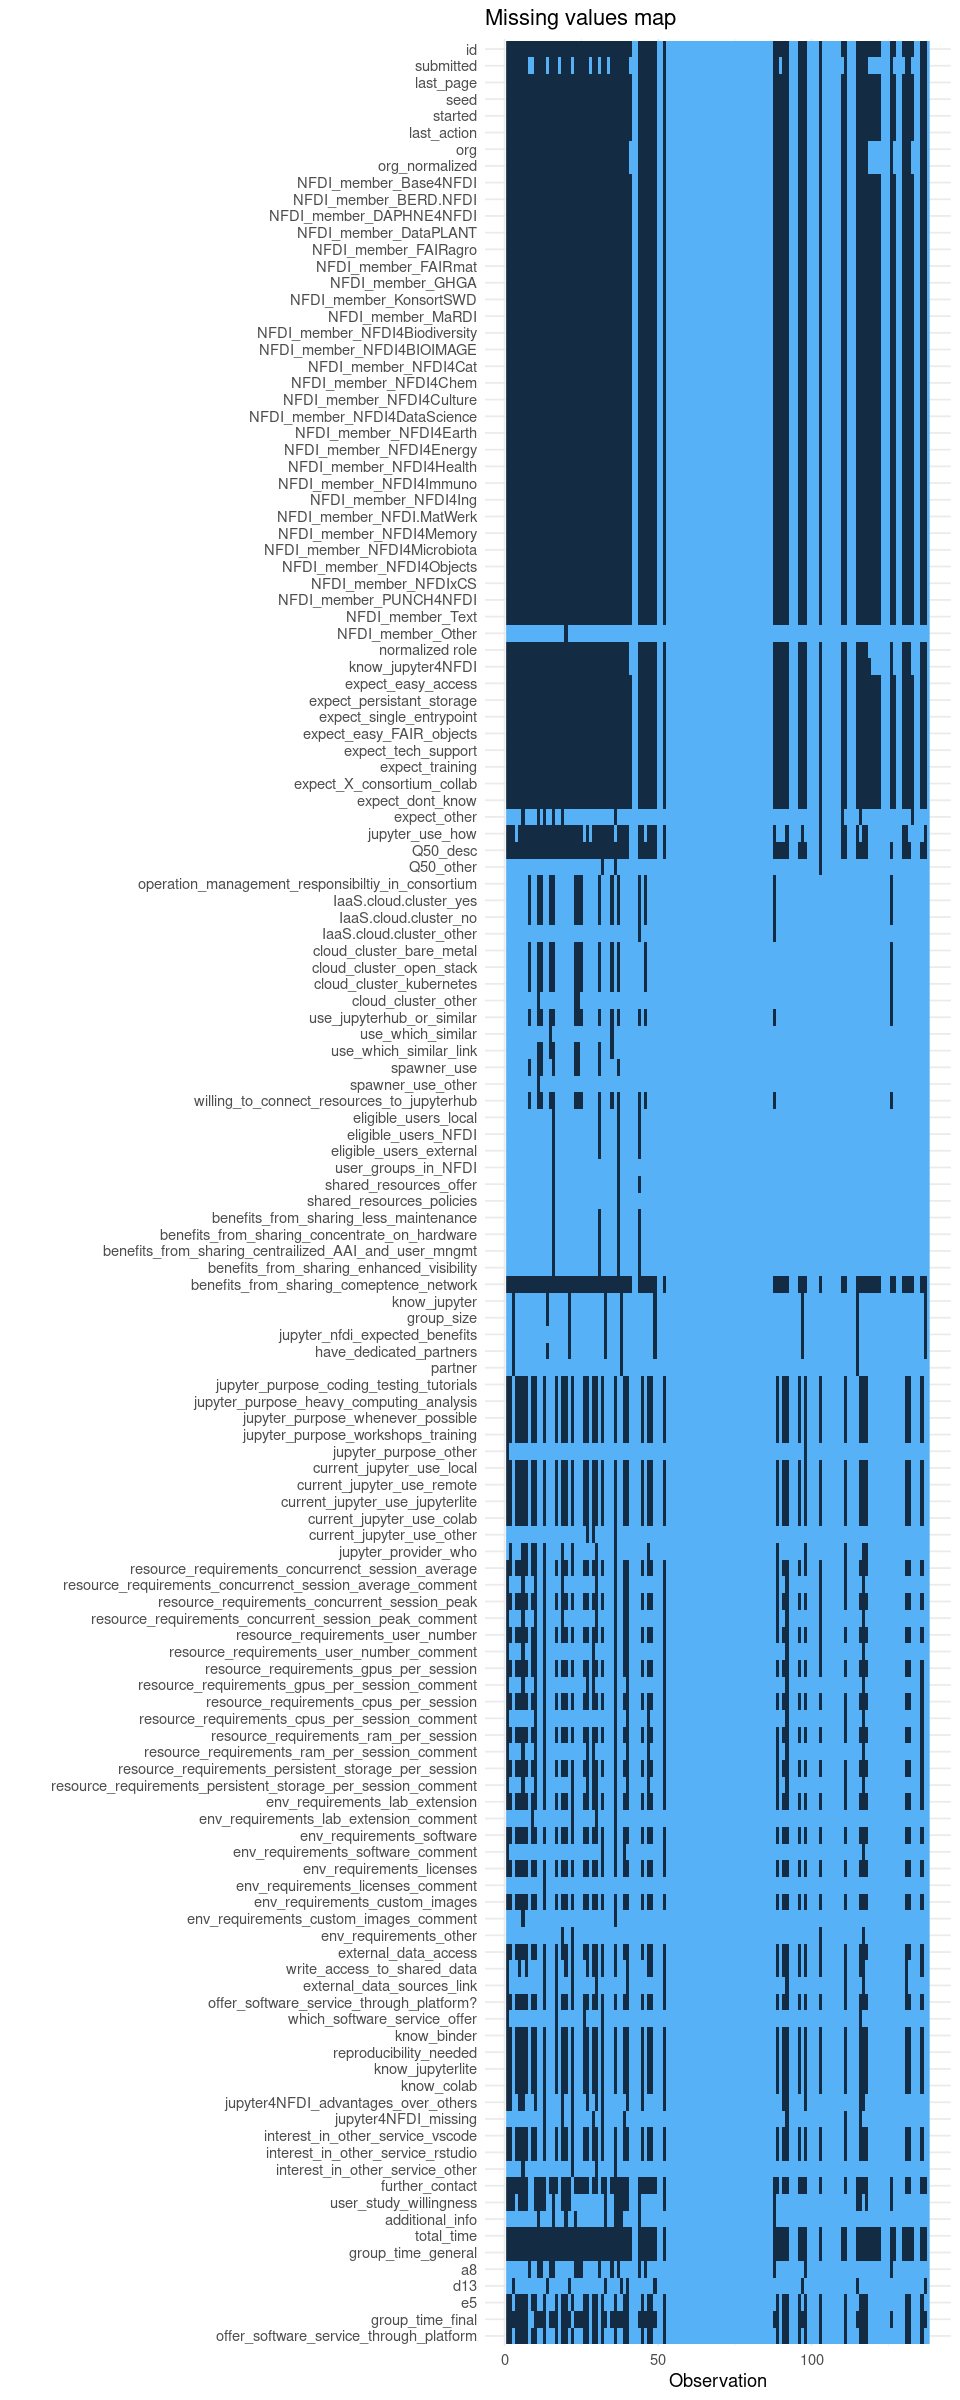

In [4]:
options(repr.plot.width = 8)
options(repr.plot.height = 20)
data_ordered <- data[order(colSums(is.na(data))), ]
missing_plot(data_ordered)

# Survey Submission Timeline

## Survey Duration

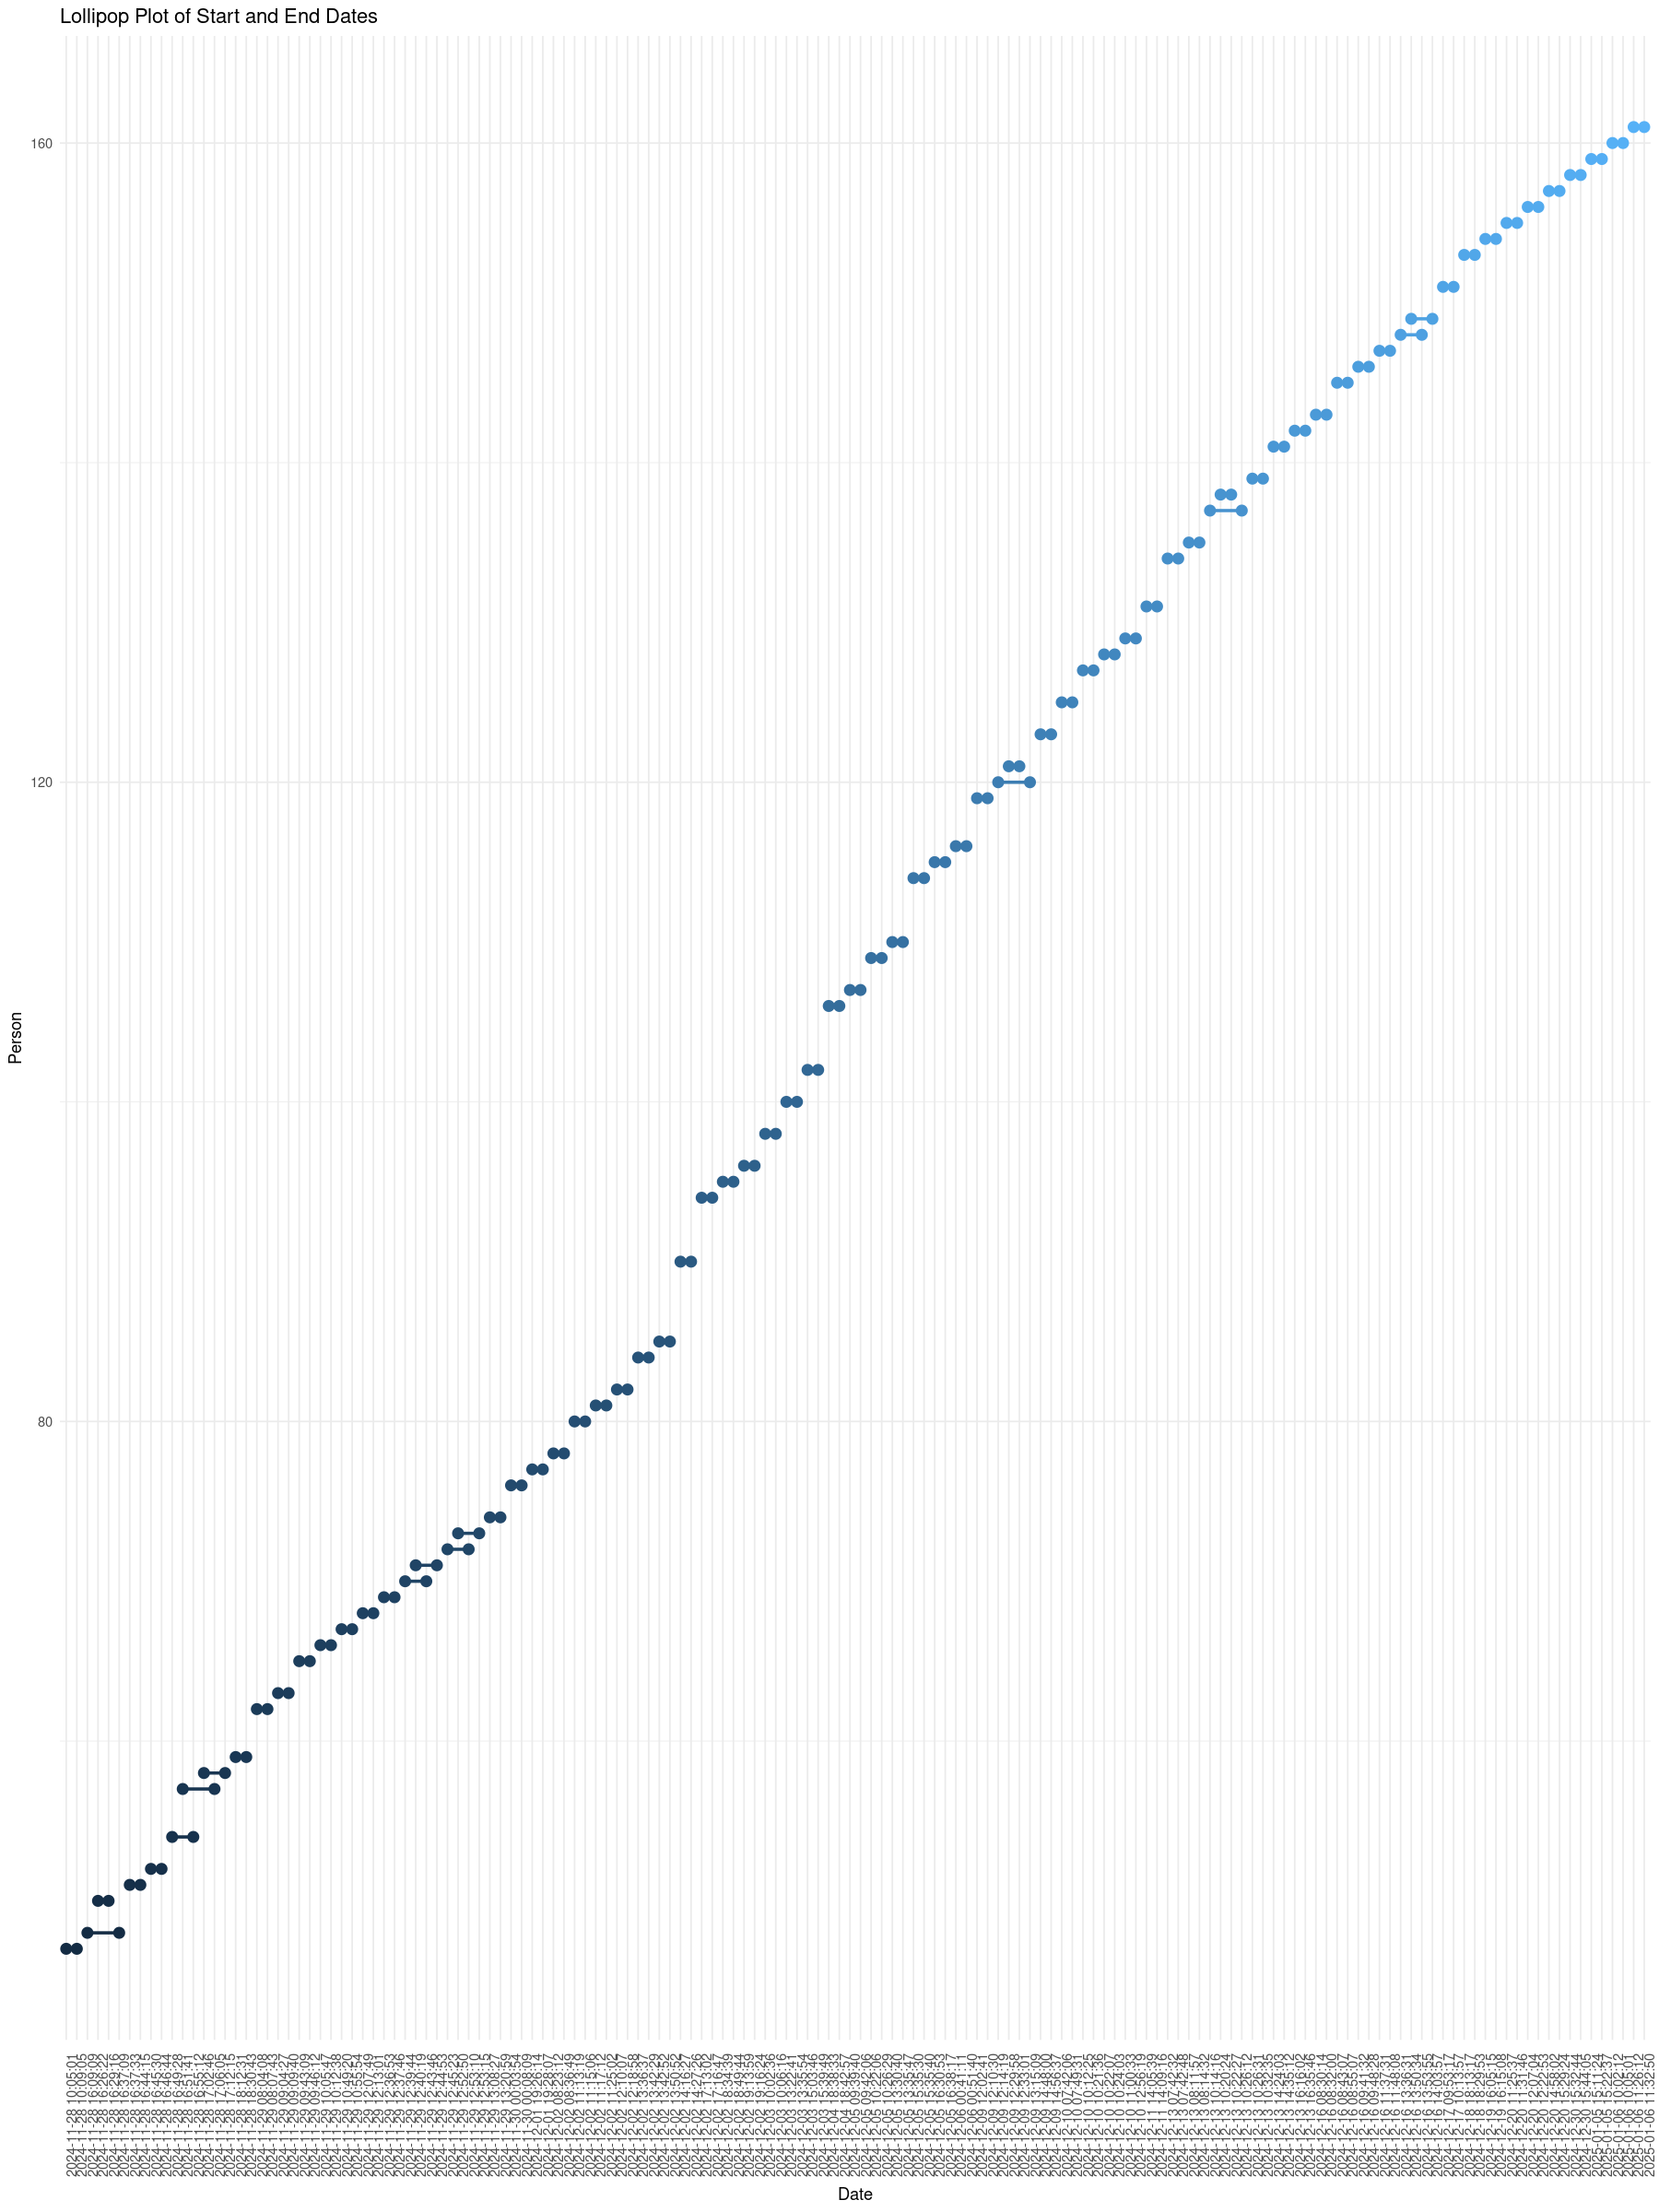

In [5]:
options(repr.plot.width = 15)
# Reshape data for lollipop plot
data_long <- data %>%
  tidyr::pivot_longer(cols = c("started", "last_action"), 
                      names_to = "DateType", 
                      values_to = "Date")

# Create the lollipop plot
ggplot(data_long, aes(x = Date, y = id, group = id)) +
  geom_line(aes(color = id), linewidth = 1) + # Line connecting start and end
  geom_point(aes(color = id), size = 3) + # Dots at start and end
  labs(
    title = "Lollipop Plot of Start and End Dates",
    x = "Date",
    y = "Person"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none", 
    axis.text.x = element_text(angle = 90, hjust = 0.5) # Vertical y-axis labels
  )

options(repr.plot.width = 7)
options(repr.plot.height = 7)

## Survey Duration

In [6]:
# Calculate summary statistics
summary_stats <- summary(data$total_time)

# Convert the summary vector into a data frame
summary_df <- data.frame(
  Statistic = names(summary_stats),
  Value = as.numeric(summary_stats)
)

# Create a nice table using kable
kable(summary_df,
      caption = "Summary of Total Time",
      col.names = c("Statistic", "Value"))




Table: Summary of Total Time

|Statistic |     Value|
|:---------|---------:|
|Min.      |    2.9100|
|1st Qu.   |  216.9400|
|Median    |  412.3300|
|Mean      |  630.2869|
|3rd Qu.   |  699.3450|
|Max.      | 6947.1200|

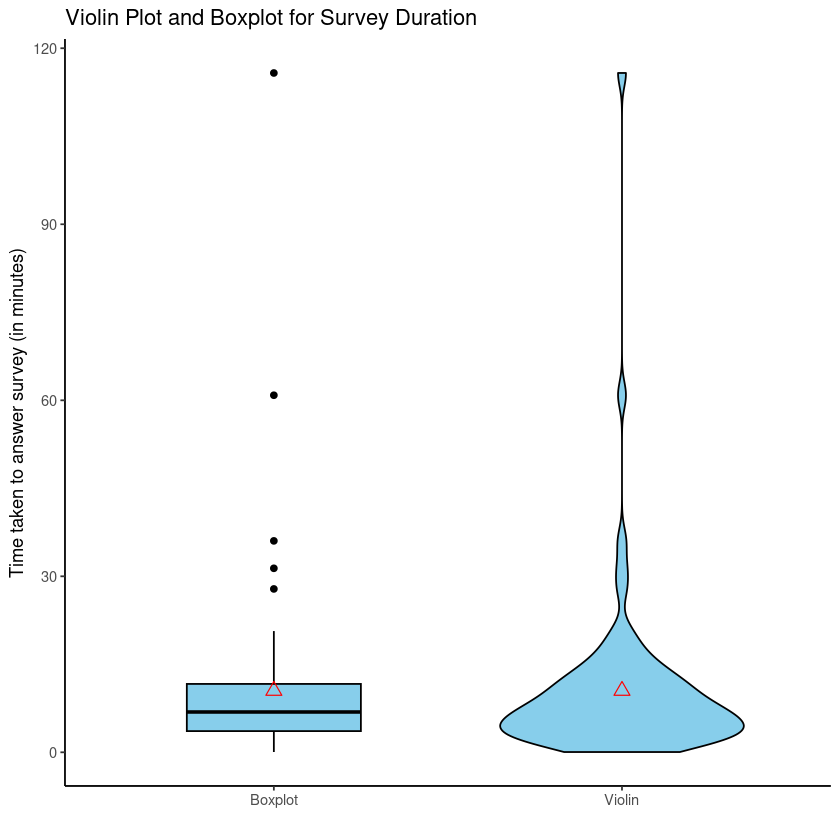

In [7]:
# plot
ggplot(data, aes(x = "Violin", y = (total_time/60))) +
  geom_violin(aes(x = "Violin"), fill = "skyblue", color = "black", width = 0.7) + # Violin
  geom_boxplot(aes(x = "Boxplot"), fill = "skyblue", color = "black", width = 0.5) + # Boxplot
  labs(
    title = "Violin Plot and Boxplot for Survey Duration",
    x = "",
    y = "Time taken to answer survey (in minutes)"
  ) +
  stat_summary(
    aes(x = "Violin"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +
  stat_summary(
    aes(x = "Boxplot"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +# Mean point for violin
  theme_classic()


# Respondent Locations

In [8]:
invisible(capture.output({
locations <- cbind.data.frame(
  Location = data$org_normalized
)

orgs_with_coords <- locations %>%
  geocode(address = Location, method = "osm")

# annotating rest manually
orgs_with_coords[is.na(orgs_with_coords$lat),]
# 1: 51.3828129,7.0210535
# 2: 51.2245443,6.8787735
# 3: 49.4095924,8.6874174
# 4: 51.6615575,7.3115184
# 5: 50.4550671,7.1179205
# 6: 51.7737587,11.1448831
# 7: 51.3432367,10.5987757
# 8: 51.3530789,10.7609292
# 9: NA
# 10: 49.7462132,9.9532957
# 11: 51.3530789,10.7609292
# 12: NA
# 13: 49.4242064,7.4497604

orgs_with_coords[is.na(orgs_with_coords$lat),]$lat <- c(51.3828129,
                                                        51.2245443,
                                                        49.4095924,
                                                        51.6615575,
                                                        50.4550671,
                                                        51.7737587,
                                                        51.3432367,
                                                        51.3530789,
                                                        NA,
                                                        49.7462132,
                                                        51.3530789,
                                                        NA,
                                                        49.4242064,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA
                                                        )

orgs_with_coords[is.na(orgs_with_coords$long),]$long <- c(7.0210535,
                                                        6.8787735,
                                                        8.6874174,
                                                        7.3115184,
                                                        7.1179205,
                                                        11.1448831,
                                                        10.5987757,
                                                        10.7609292,
                                                        NA,
                                                        9.9532957,
                                                        10.7609292,
                                                        NA,
                                                        7.4497604,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA
)

# removing empties
orgs_with_coords <- orgs_with_coords[!is.na(orgs_with_coords$lat),]

# fixing wrong ones manually
# 12: Kassel
# 23: EMBL Hamburg
# 35: FLI Institute
# 42: Leibniz Institut for Astrophicsis Potsdam
orgs_with_coords[12,2:3] <- list(51.3147254,9.479618)
orgs_with_coords[23,2:3] <- list(53.578086,9.8802713)
orgs_with_coords[35,2:3] <- list(52.5195955,8.7884747)
orgs_with_coords[42,2:3] <- list(52.4044516,13.1014999)

}))

Passing 53 addresses to the Nominatim single address geocoder

Query completed in: 53.2 seconds



In [9]:
# making interactive map
leaflet(orgs_with_coords) %>%
  addTiles() %>%
  addCircles(
    ~long, ~lat,
    popup = ~Location,
    radius = 10,
    color = "red", fill = TRUE, fillOpacity = 0.5
  )


HTML widgets cannot be represented in plain text (need html)

# NFDI Consortia

In [10]:
invisible(capture.output({
# Transform data to right format
binary_columns <- data[,9:35]
sapply(binary_columns, class)
for (i in 1:dim(binary_columns)[2]) {
  binary_columns[,i] <- as.factor(binary_columns[,i])
}
binary_columns <- sapply(binary_columns,as.numeric)
binary_columns <- (binary_columns - 1)
sums <- as.data.frame(colSums(binary_columns, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)
}))

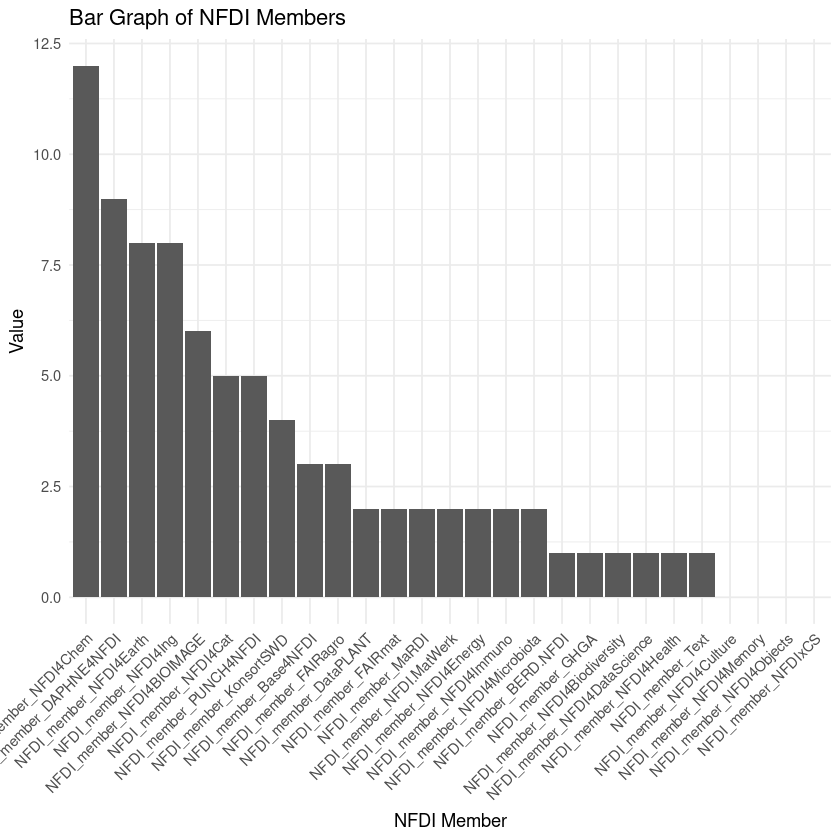

In [11]:
# Create bar graph
ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of NFDI Members",
    x = "NFDI Member",
    y = "Value"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

## Other Consortia

In [12]:
# other NFDI
data$NFDI_member_Other[!is.na(data$NFDI_member_Other)]


[1] "de.KCD"

# Role of survey respondents

In [13]:
invisible(capture.output({
data$`normalized role`[data$`normalized role` == FALSE] <- NA
table(data$`normalized role`,useNA = "always")
role_frame <- as.data.frame(table(data$`normalized role`,useNA = "always"))
colnames(role_frame) <- c("Role","Count")
role_frame <- role_frame[order(role_frame$Count,decreasing = T),]
role_frame$Role <- factor(role_frame$Role, levels = role_frame$Role) 
}))

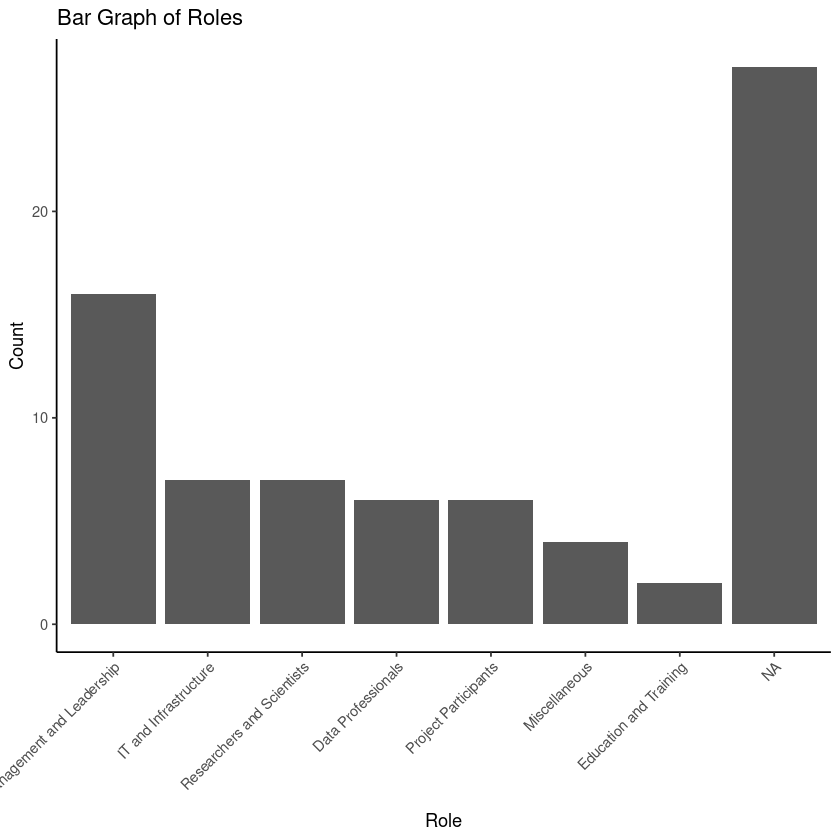

In [14]:
# Barplot
ggplot(role_frame, aes(x = Role, y = Count)) + 
  geom_bar(stat = "identity") +
  theme_classic() +
  labs(
    title = "Bar Graph of Roles",
    x = "Role",
    y = "Count"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Knowing Jupyter

In [15]:
table(data$know_jupyter4NFDI,useNA = "always")
prop.table(table(data$know_jupyter4NFDI,useNA = "always"))
know_jupyter4NFDI_frame <- as.data.frame(table(data$know_jupyter4NFDI,useNA = "always"))
colnames(know_jupyter4NFDI_frame) <- c("Knows","Count")
know_jupyter4NFDI_frame <- know_jupyter4NFDI_frame[order(know_jupyter4NFDI_frame$Count,decreasing = T),]
know_jupyter4NFDI_frame$Knows <- factor(know_jupyter4NFDI_frame$Knows, levels = know_jupyter4NFDI_frame$Knows)


  No  Yes <NA> 
  33   36    6 


  No  Yes <NA> 
0.44 0.48 0.08 

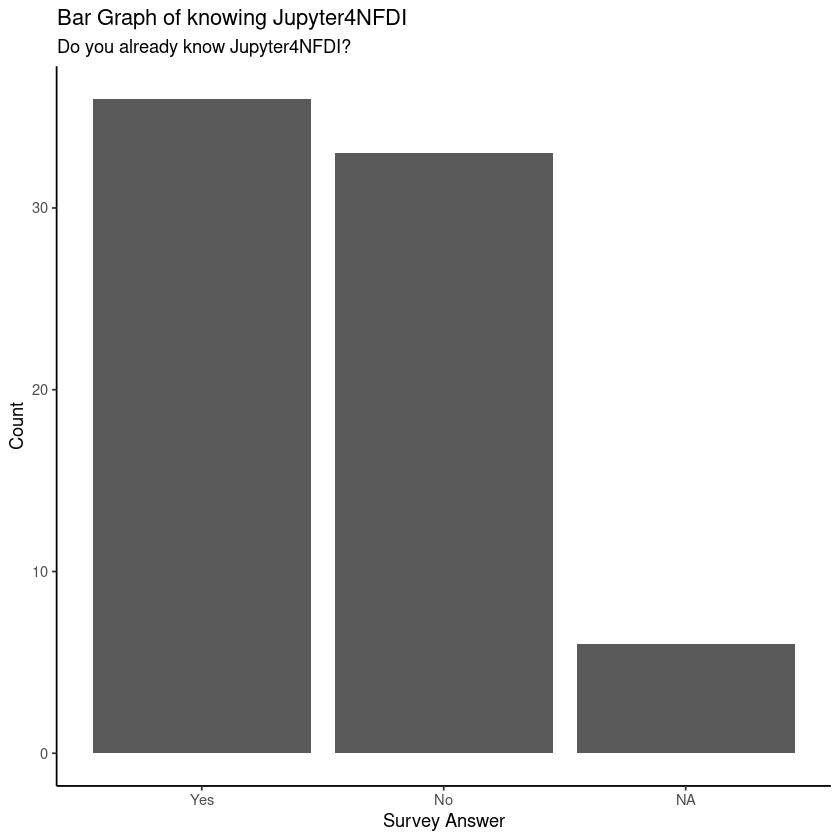

In [16]:
# Barplot
ggplot(know_jupyter4NFDI_frame, aes(x = Knows, y = Count)) + 
  geom_bar(stat = "identity") +
  theme_classic() +
  labs(
    title = "Bar Graph of knowing Jupyter4NFDI",
    x = "Survey Answer",
    y = "Count",
    subtitle = "Do you already know Jupyter4NFDI?"
  )


# Knowing Jupyter by Role

In [17]:
invisible(capture.output({
# Create a contingency table and transform it to a data frame
know_jupyter4NFDI_role_frame <- as.data.frame(table(data$`normalized role`, data$know_jupyter4NFDI, useNA = "always"))

# Pivot the table to a wide format
know_jupyter4NFDI_role_frame_wide <- reshape(know_jupyter4NFDI_role_frame,
                                            idvar = "Var1", 
                                            timevar = "Var2", 
                                            direction = "wide")

# Clean up the column names
colnames(know_jupyter4NFDI_role_frame_wide) <- c("Role", "No", "Yes", "NA")

# Optionally, create a nice table using kable
kable(know_jupyter4NFDI_role_frame_wide,
      caption = "Knowing Jupyter by Role",
      col.names = c("Role", "No", "Yes", "NA"))
}))

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”


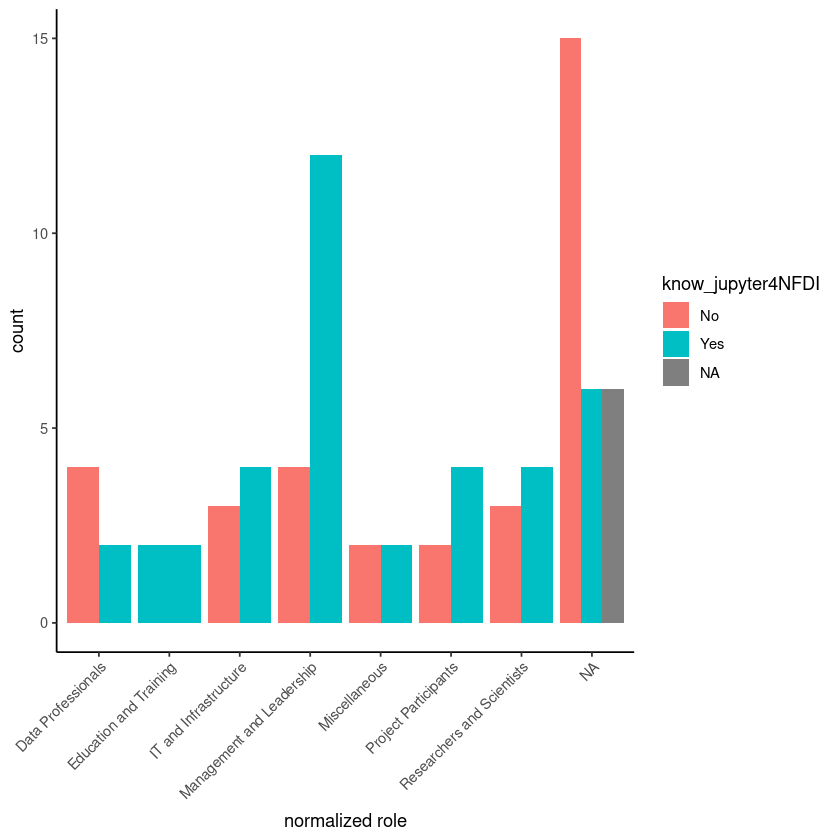

In [18]:
# stacked bar chart
ggplot(data, aes(x = `normalized role`, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Knowing Jupyter by Consortium

In [19]:
binary_columns_mat <- as.matrix(binary_columns)
column_indices <- apply(binary_columns_mat, 1, which.max)
consortium_factor <- as.factor(column_indices)
levels(consortium_factor) <- substr(colnames(binary_columns),13,100)[as.numeric((levels(consortium_factor)))]
data$consortium <- consortium_factor


In [20]:
# Create a contingency table and transform it to a data frame
know_jupyter4NFDI_consortium_frame <- as.data.frame(table(data$consortium, data$know_jupyter4NFDI, useNA = "always"))

# Pivot the table to a wide format
know_jupyter4NFDI_consortium_frame_wide <- reshape(know_jupyter4NFDI_consortium_frame,
                                            idvar = "Var1", 
                                            timevar = "Var2", 
                                            direction = "wide")

# Clean up the column names
colnames(know_jupyter4NFDI_consortium_frame_wide) <- c("Role", "No", "Yes", "NA")

# Optionally, create a nice table using kable
kable(know_jupyter4NFDI_consortium_frame_wide,
      caption = "Knowing Jupyter by consortium",
      col.names = c("Role", "No", "Yes", "NA"))

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”




Table: Knowing Jupyter by consortium

|Role              | No| Yes| NA|
|:-----------------|--:|---:|--:|
|Base4NFDI         |  0|   5|  6|
|BERD.NFDI         |  1|   0|  0|
|DAPHNE4NFDI       |  7|   2|  0|
|DataPLANT         |  0|   1|  0|
|FAIRagro          |  1|   2|  0|
|FAIRmat           |  2|   0|  0|
|GHGA              |  0|   1|  0|
|KonsortSWD        |  3|   1|  0|
|MaRDI             |  0|   1|  0|
|NFDI4Biodiversity |  1|   0|  0|
|NFDI4BIOIMAGE     |  2|   3|  0|
|NFDI4Cat          |  1|   3|  0|
|NFDI4Chem         |  7|   1|  0|
|NFDI4Earth        |  3|   4|  0|
|NFDI4Energy       |  0|   2|  0|
|NFDI4Immuno       |  0|   2|  0|
|NFDI4Ing          |  2|   6|  0|
|PUNCH4NFDI        |  2|   2|  0|
|Text              |  1|   0|  0|
|NA                |  0|   0|  0|

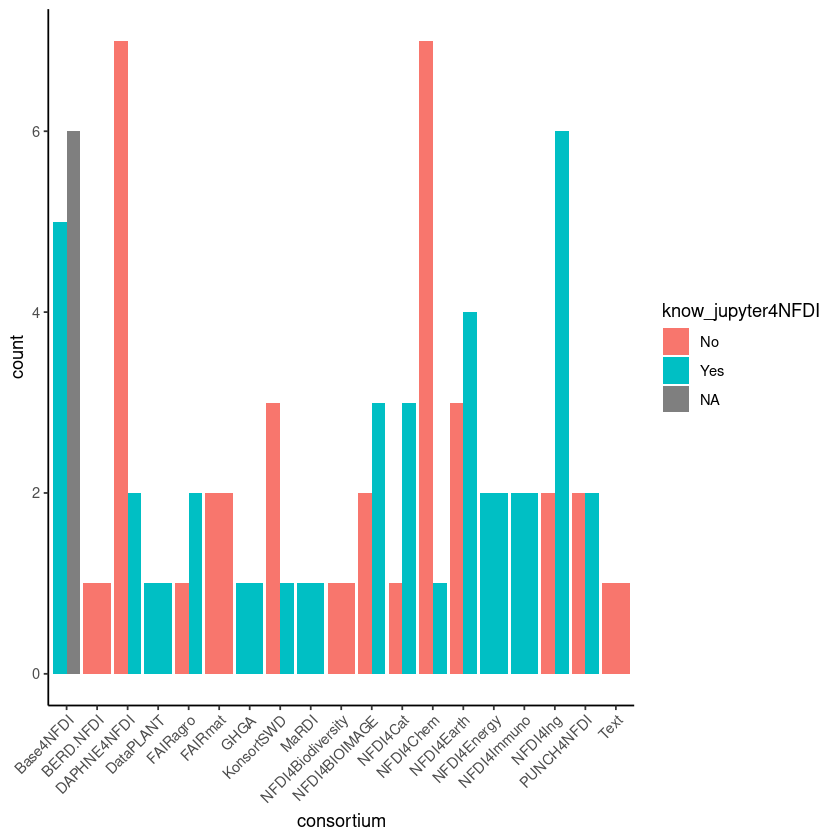

In [21]:
# stacked bar chart
ggplot(data, aes(x = consortium, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Expectations

In [22]:
invisible(capture.output({
expect_frame <- data[,39:46]
sapply(expect_frame, class)
for (i in 1:dim(expect_frame)[2]) {
  expect_frame[,i] <- as.factor(expect_frame[,i])
}
expect_frame <- sapply(expect_frame,as.numeric)
expect_frame <- (expect_frame - 1)
sums <- as.data.frame(colSums(expect_frame, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)
}))

In [23]:
# Pivot the table to a wide format (to prevent long format)
sums2 <- reshape(sums,
                 idvar = "Value",
                 timevar = "Name",
                 direction = "wide")

# Optionally, create a nice table using kable
kable(sums2,
      caption = "Expectations",
      col.names = c("Expectation","Count")
      )




Table: Expectations

|Expectation                | Count|
|:--------------------------|-----:|
|expect_easy_access         |    53|
|expect_persistant_storage  |    27|
|expect_single_entrypoint   |    40|
|expect_easy_FAIR_objects   |    26|
|expect_tech_support        |    24|
|expect_training            |    28|
|expect_X_consortium_collab |    22|
|expect_dont_know           |     9|

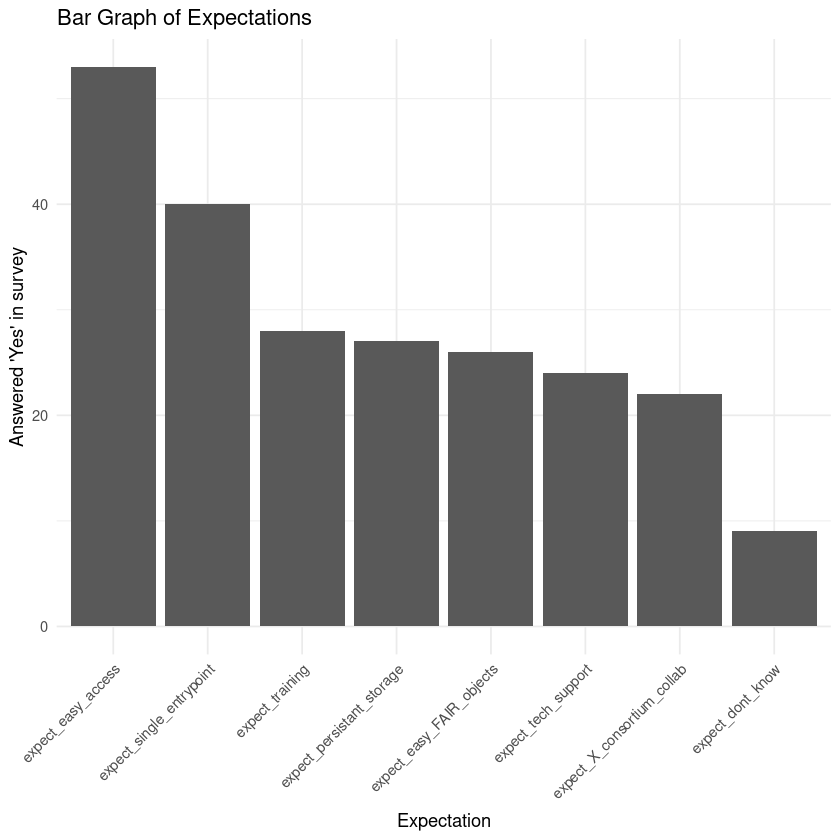

In [24]:
# Create bar graph
ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of Expectations",
    x = "Expectation",
    y = "Answered 'Yes' in survey"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


### Other Expectations

In [25]:
# other NFDI
data$expect_other[!is.na(data$expect_other)]

[1] "possibility to create/use custom images"                                                                                                                                                                      
 [2] "A frontend to select which JupyterHub resource to use. "                                                                                                                                                      
 [3] "enhanced reproducibility"                                                                                                                                                                                     
 [4] "Federation across different institutes (e.g. federated storage)"                                                                                                                                              
 [5] "A teaching instance."                                                                                                                                                                                         
 [6] "gpus tests for prototyping large ml/llm projects"                                                                                                                                                             
 [7] "Code contributions to Jupyter"                                                                                                                                                                                
 [8] "I clicked on \"Persisten storage\" but would rather expect the data to be stored for a limited time only; or during which the analyses run. I would also expect tutorial on how to get the data into the Hub."
 [9] "provide computing env for NFDI training materials"                                                                                                                                                            
[10] "Nothing useful. "

# Consortium Role

In [26]:
# Survey taker consortium role
data$Q50_desc[data$Q50_desc == "User (single-person or, for example, teacher/trainer)"] <- "User"
data$Q50_desc[data$Q50_desc == "Community or Research Alliance Representative / Consortium Manager"] <- "Representative/Manager"

#table(data$Q50_desc, useNA = "always")
#prop.table(table(data$Q50_desc, useNA = "always"))*100
cons_role_frame <- as.data.frame(table(data$Q50_desc, useNA = "always"))

# Optionally, create a nice table using kable
kable(cons_role_frame,
      caption = "Consortium Role",
      col.names = c("Consortium Role","Count")
      )





Table: Consortium Role

|Consortium Role        | Count|
|:----------------------|-----:|
|Other                  |     3|
|Representative/Manager |    10|
|Resource Provider      |    17|
|User                   |    38|
|NA                     |     7|

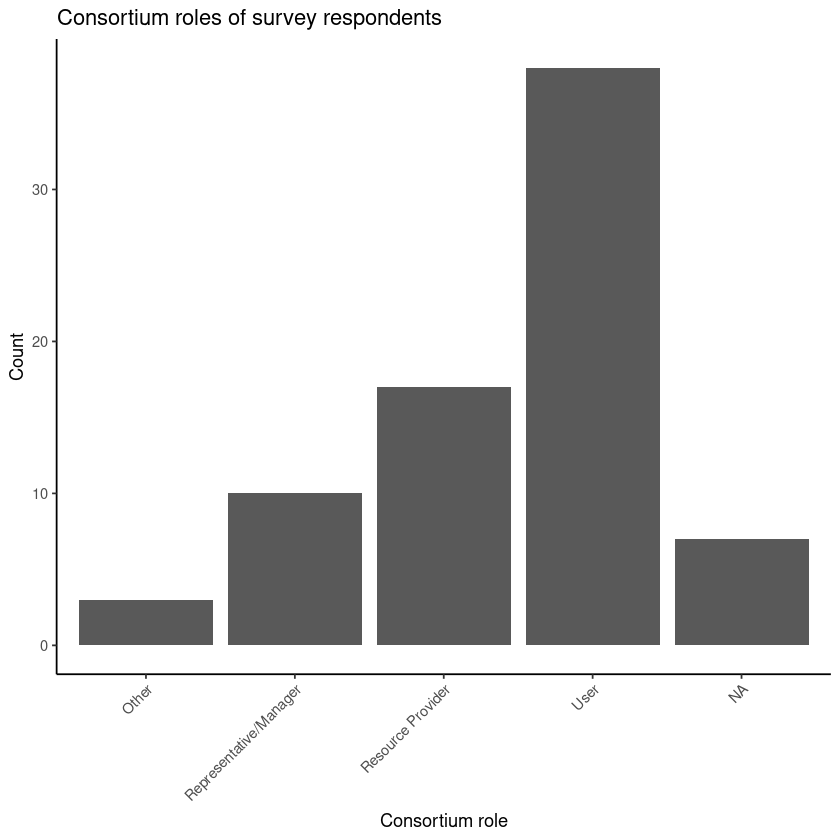

In [27]:
# stacked bar chart
ggplot(data, aes(x = Q50_desc)) + 
  geom_bar() +
  labs(title = "Consortium roles of survey respondents",
       x = "Consortium role",
       y = "Count") +
  theme_classic() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


## Knowing Jupyter by Consortium role

In [28]:
# know jupyter by role
#table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always")
#prop.table(table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always"))*100

know_jupy_by_cons_role_frame <- table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always")

# Optionally, create a nice table using kable
kable(know_jupy_by_cons_role_frame,
      caption = "Knowing Jupyter by Consortium Role",
      col.names = c("Role", "No", "Yes", "NA"))




Table: Knowing Jupyter by Consortium Role

|Role                   | No| Yes| NA|
|:----------------------|--:|---:|--:|
|Other                  |  0|   3|  0|
|Representative/Manager |  6|   4|  0|
|Resource Provider      |  6|  11|  0|
|User                   | 21|  17|  0|
|NA                     |  0|   1|  6|

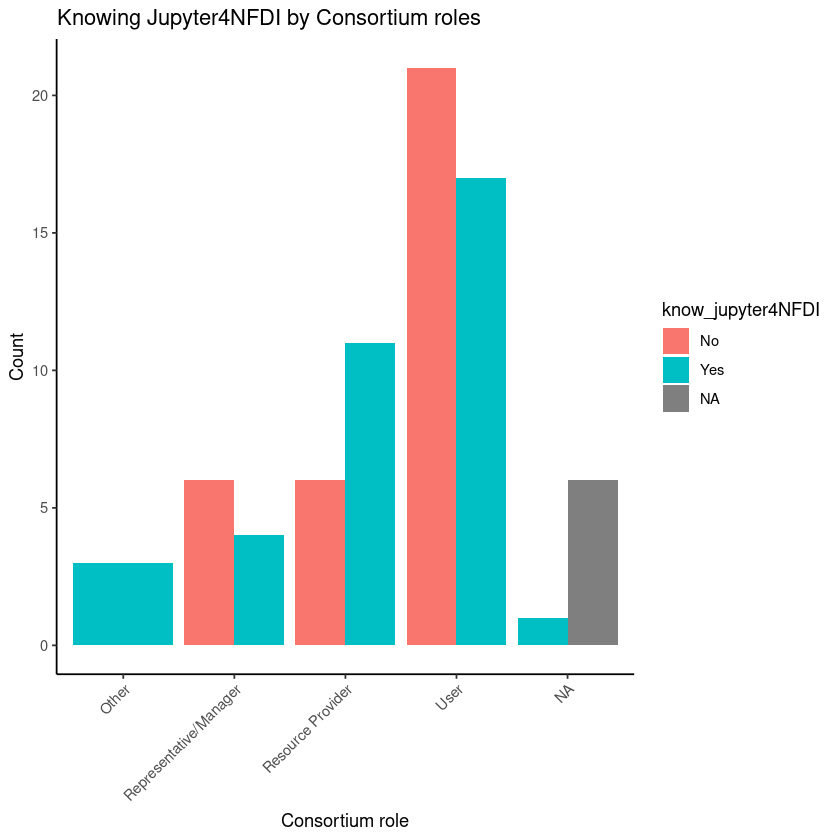

In [29]:
# stacked bar chart
ggplot(data, aes(x = Q50_desc, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  labs(title = "Knowing Jupyter4NFDI by Consortium roles",
       x = "Consortium role",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Operating Management Responsibility

In [30]:
#data$operation_management_responsibiltiy_in_consortium[!is.na(data$operation_management_responsibiltiy_in_consortium)]
#table(data$operation_management_responsibiltiy_in_consortium,useNA = "always")
#prop.table(table(data$operation_management_responsibiltiy_in_consortium,useNA = "always"))*100

op_resp_frame <- as.data.frame(table(data$operation_management_responsibiltiy_in_consortium,useNA = "always"))

# Optionally, create a nice table using kable
kable(op_resp_frame,
      caption = "Operating Management Responsibility",
      col.names = c("Responsibility","Frequency"))



Table: Operating Management Responsibility

|Responsibility                                                        | Frequency|
|:---------------------------------------------------------------------|---------:|
|No.                                                                   |         8|
|Yes, I’m responsible for at least one infrastructure and one service. |         4|
|Yes, I’m responsible for at least one infrastructure.                 |         1|
|Yes, I’m responsible for at least one service.                        |         2|
|NA                                                                    |        60|

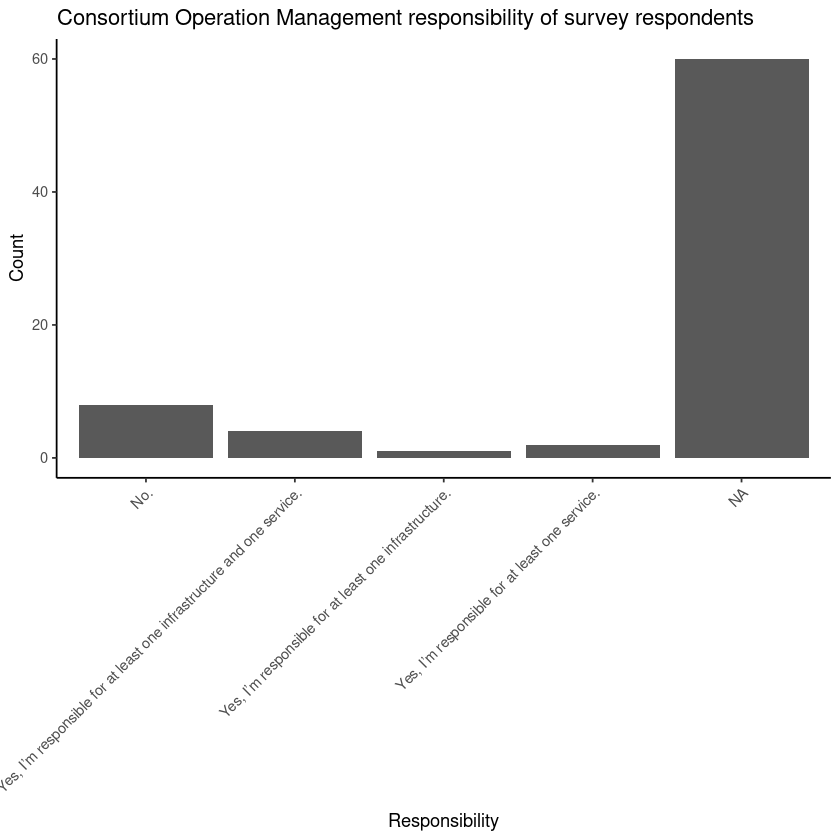

In [31]:
# stacked bar chart
ggplot(data, aes(x = operation_management_responsibiltiy_in_consortium)) + 
  geom_bar() +
  labs(title = "Consortium Operation Management responsibility of survey respondents",
       x = "Responsibility",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Op Management Responsibility by knowing Jupyter

In [32]:
# know jupyter by responsibility
#table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always")
#prop.table(table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always"))*100

op_resp_by_jup_frame <- as.data.frame(table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always"))


# Pivot the table to a wide format (to prevent long format)
op_resp_by_jup_frame2 <- reshape(op_resp_by_jup_frame,
                 idvar = "Var1",
                 timevar = "Var2",
                 direction = "wide")

# Optionally, create a nice table using kable
kable(op_resp_by_jup_frame2,
      caption = "Operating Management Responsibility by Jupyter Knowledge",
      col.names = c("Responsibility","Know Jupyter - No", "Know Jupyter - Yes","NA"))

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”




Table: Operating Management Responsibility by Jupyter Knowledge

|Responsibility                                                        | Know Jupyter - No| Know Jupyter - Yes| NA|
|:---------------------------------------------------------------------|-----------------:|------------------:|--:|
|No.                                                                   |                 3|                  5|  0|
|Yes, I’m responsible for at least one infrastructure and one service. |                 1|                  3|  0|
|Yes, I’m responsible for at least one infrastructure.                 |                 1|                  0|  0|
|Yes, I’m responsible for at least one service.                        |                 1|                  1|  0|
|NA                                                                    |                27|                 27|  6|

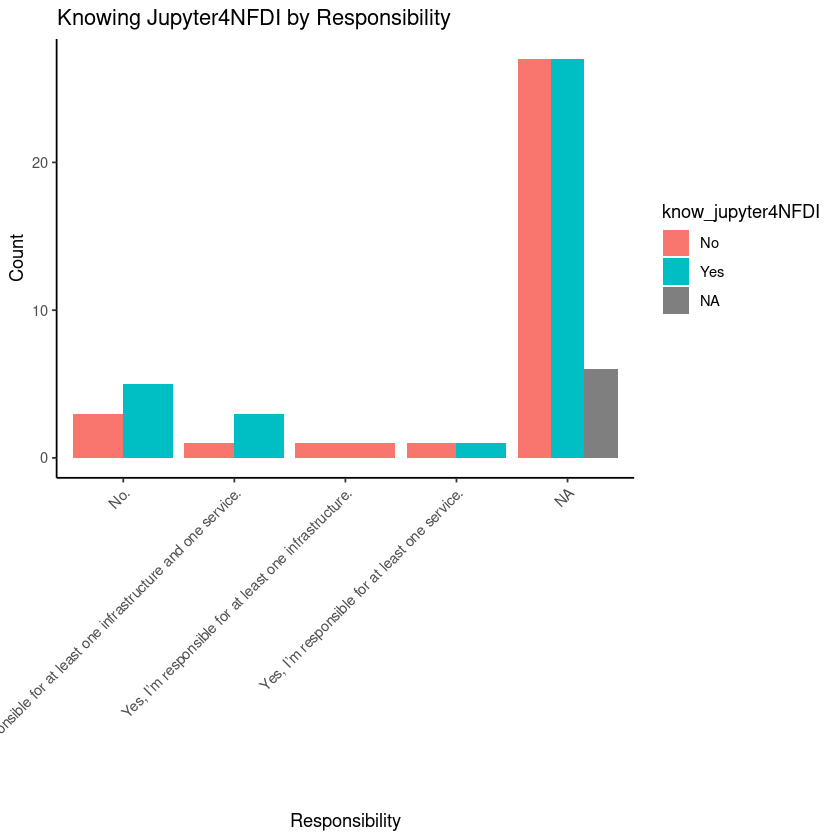

In [33]:
# stacked bar chart
ggplot(data, aes(x = operation_management_responsibiltiy_in_consortium, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  labs(title = "Knowing Jupyter4NFDI by Responsibility",
       x = "Responsibility",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# IaaS Cloud Cluster



|Var1 | Freq|
|:----|----:|
|No   |    8|
|Yes  |    7|
|NA   |   60|

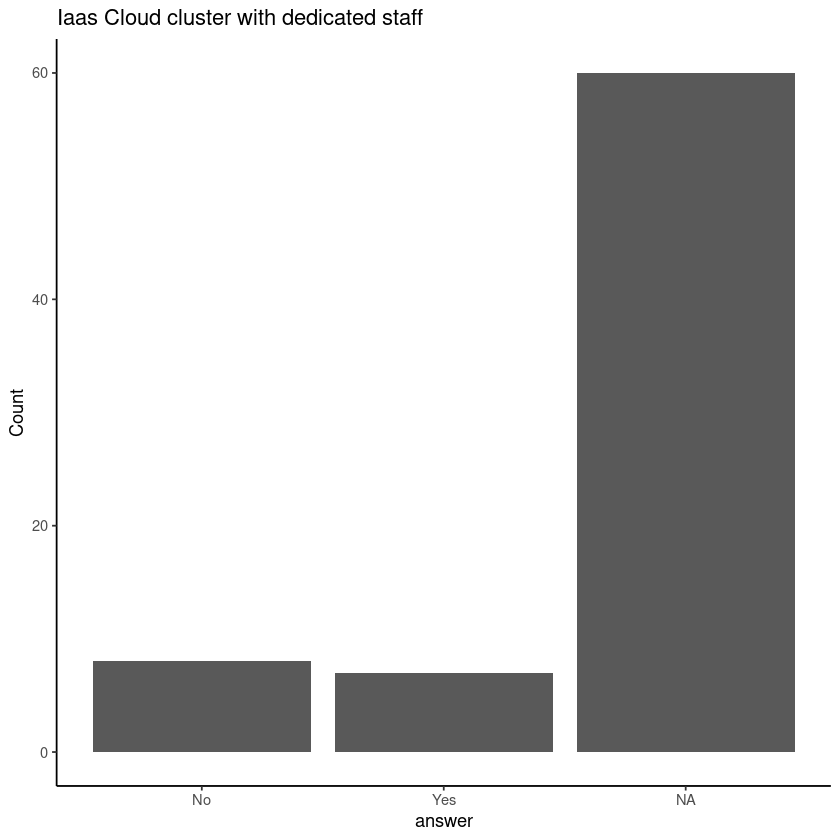

In [34]:
kable(data.frame(table(data$IaaS.cloud.cluster_yes, useNA = "always")))
#prop.table(table(data$IaaS.cloud.cluster_yes, useNA = "always"))*100

# stacked bar chart
ggplot(data, aes(x = IaaS.cloud.cluster_yes)) + 
  geom_bar() +
  labs(title = "Iaas Cloud cluster with dedicated staff",
       x = "answer",
       y = "Count") +
  theme_classic()





|Var1 | Freq|
|:----|----:|
|No   |    8|
|Yes  |    7|
|NA   |   60|

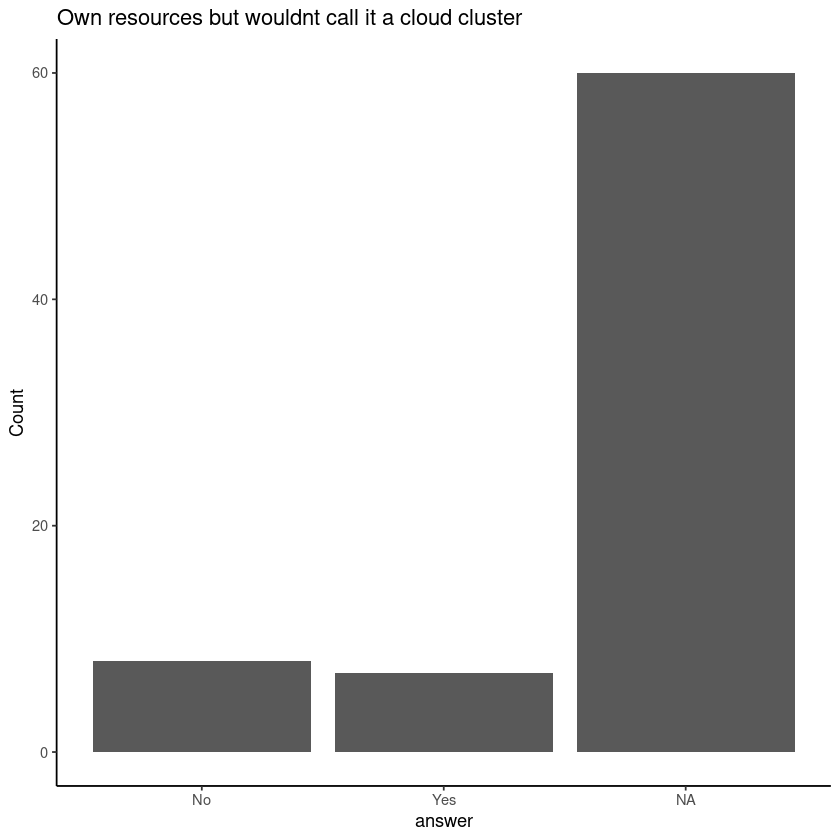

In [35]:
kable(data.frame(table(data$IaaS.cloud.cluster_no, useNA = "always")))

# stacked bar chart
ggplot(data, aes(x = IaaS.cloud.cluster_no)) + 
  geom_bar() +
  labs(title = "Own resources but wouldnt call it a cloud cluster",
       x = "answer",
       y = "Count") +
  theme_classic()


## IaaS Cloud Cluster other

In [36]:
# Other cloud cluster responses
data$IaaS.cloud.cluster_other[!is.na(data$IaaS.cloud.cluster_other)]

[1] "I am not sure" "no"

# Cloud Cluster

In [37]:
invisible(capture.output({
cloud_cluster_frame <- data[,55:57]
sapply(cloud_cluster_frame, class)
for (i in 1:dim(cloud_cluster_frame)[2]) {
  cloud_cluster_frame[,i] <- as.factor(cloud_cluster_frame[,i])
}
cloud_cluster_frame <- sapply(cloud_cluster_frame,as.numeric)
cloud_cluster_frame <- (cloud_cluster_frame - 1)
sums <- as.data.frame(colSums(cloud_cluster_frame, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)

}))

In [38]:
row.names(sums) <- NULL
kable(sums[,c(2,1)])




|Name                     | Value|
|:------------------------|-----:|
|cloud_cluster_bare_metal |     9|
|cloud_cluster_open_stack |     3|
|cloud_cluster_kubernetes |     6|

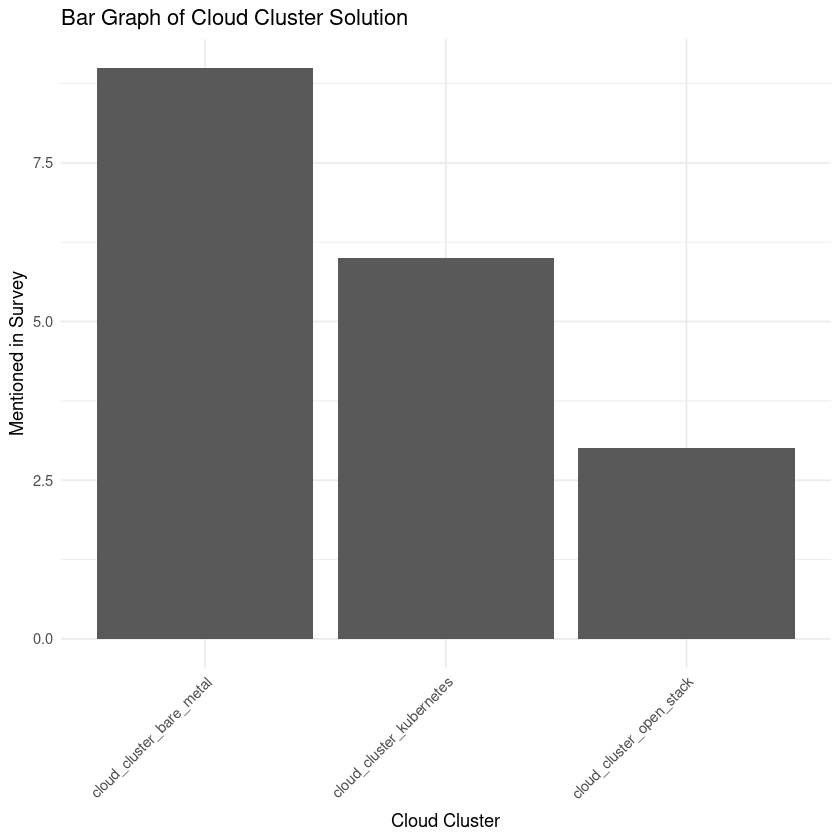

In [39]:
# Create bar graph
ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of Cloud Cluster Solution",
    x = "Cloud Cluster",
    y = "Mentioned in Survey"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## cloud Cluster other

In [40]:
# other NFDI
data$cloud_cluster_other[!is.na(data$cloud_cluster_other)]

[1] "libvirt / KVM, HTCondor with containers"
[2] "VMware"                                 
[3] "Docker, VM"                             
[4] "BinderHub"

# Using JupyterHub (or similar)

In [41]:
# table(data$use_jupyterhub_or_similar, useNA = "always")
# prop.table(table(data$use_jupyterhub_or_similar, useNA = "always"))*100
jupyter_hub_frame <- data.frame(table(data$use_jupyterhub_or_similar, useNA = "always"))
kable(jupyter_hub_frame,
      col.names = c("Using Service","Answer Count"))



|Using Service   | Answer Count|
|:---------------|------------:|
|JupyterHub      |            8|
|No              |            5|
|Similar service |            2|
|NA              |           60|

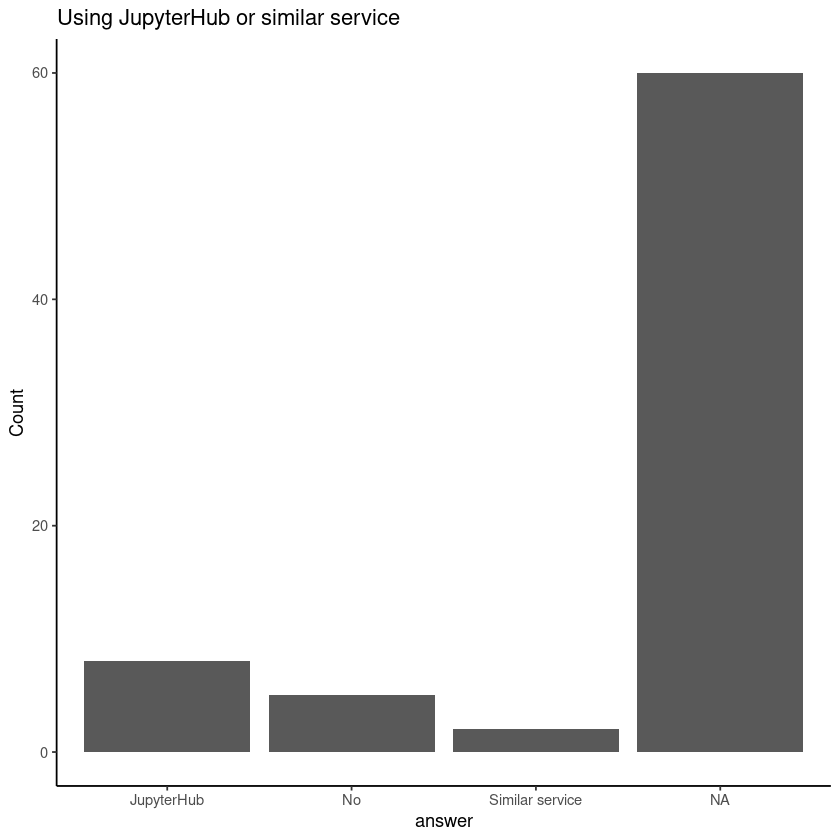

In [42]:
# stacked bar chart
ggplot(data, aes(x = use_jupyterhub_or_similar)) + 
  geom_bar() +
  labs(title = "Using JupyterHub or similar service",
       x = "answer",
       y = "Count") +
  theme_classic()


## Other Services

In [43]:
# which similar
data$use_which_similar[!is.na(data$use_which_similar)]

[1] "ArcGIS Notebookserver" "Galaxy"

In [44]:
# links
data$use_which_similar_link[!is.na(data$use_which_similar_link)]
links <- rm_url(data$use_which_similar_link[!is.na(data$use_which_similar_link)], extract = T)
links <- unlist(links)
links <- links[!is.na(links)]
links


[1] "No: in development / internal"      "https://jupyterhub.uni-muenster.de"
[3] "No, it is for internal use only."   "currently internal"                
[5] "No, internal-only"                  "not available publicly"            
[7] "https://jhub.photonicdata.science"  "https://usegalaxy.eu"

[1] "https://jupyterhub.uni-muenster.de" "https://jhub.photonicdata.science" 
[3] "https://usegalaxy.eu"

# Spawner Use

In [45]:
#table(data$spawner_use, useNA = "always")
#prop.table(table(data$spawner_use, useNA = "always"))*100
spawner_frame <- data.frame(table(data$spawner_use, useNA = "always"))
kable(spawner_frame)





|Var1          | Freq|
|:-------------|----:|
|DockerSpawner |    1|
|KubeSpawner   |    4|
|LocalSpawner  |    1|
|Other         |    2|
|NA            |   67|

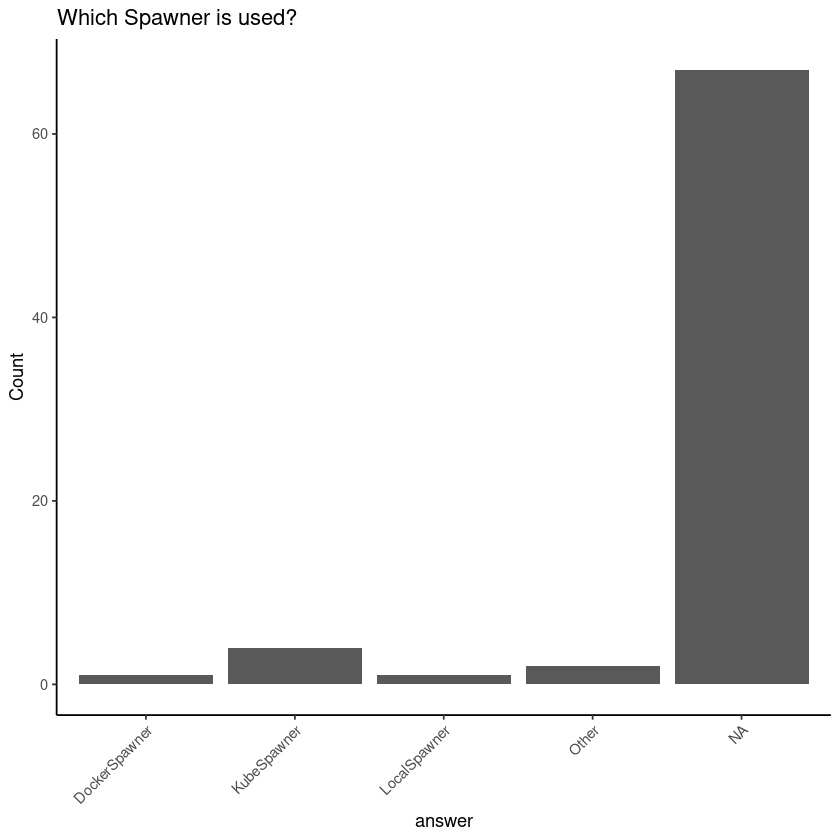

In [46]:
# stacked bar chart
ggplot(data, aes(x = spawner_use)) + 
  geom_bar() +
  labs(title = "Which Spawner is used?",
       x = "answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Other Spawners

In [47]:

# which similar
data$spawner_use_other[!is.na(data$spawner_use_other)]



[1] "BatchSpawner extended with public code for safe use with federated computing infrastructures. "

# Willingness to connect to JupyterHub

In [48]:
# Willingness to connect own resources to central JupyterHub
#table(data$spawner_use, useNA = "always")
#prop.table(table(data$spawner_use, useNA = "always"))*100
willingness_frame <- data.frame(table(data$willing_to_connect_resources_to_jupyterhub, useNA = "always"))
kable(willingness_frame)




|Var1                                         | Freq|
|:--------------------------------------------|----:|
|No                                           |   11|
|Yes, but only for a specified group of users |    4|
|NA                                           |   60|

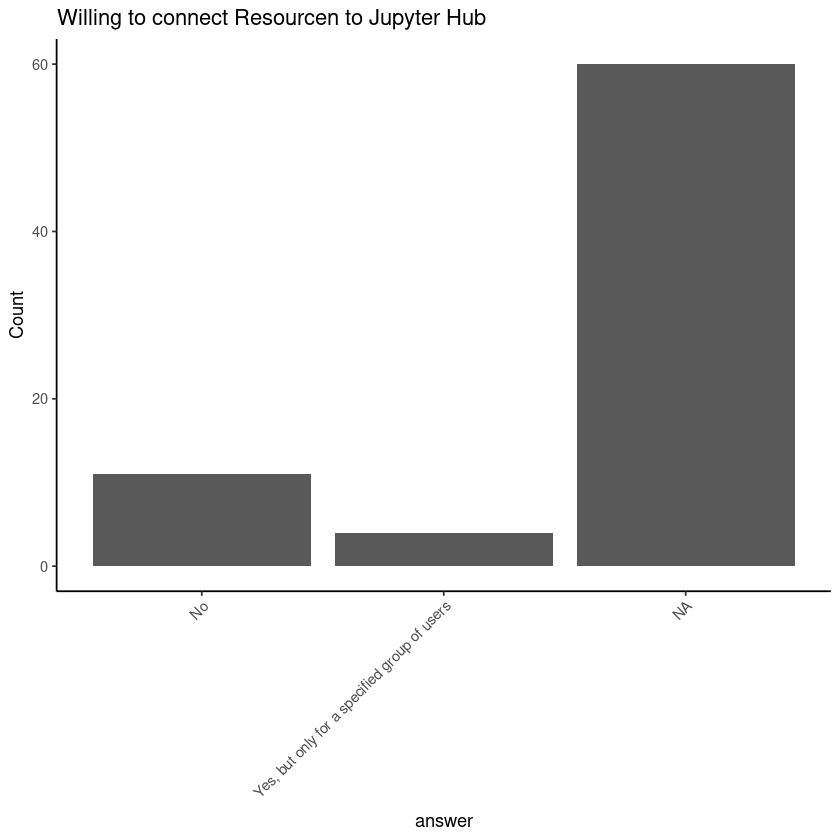

In [49]:
# stacked bar chart
ggplot(data, aes(x = willing_to_connect_resources_to_jupyterhub)) + 
  geom_bar() +
  labs(title = "Willing to connect Resourcen to Jupyter Hub",
       x = "answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Eligible User Groups for shared Resources

In [50]:
invisible(capture.output({
data$eligible_users_local  <- as.factor(data$eligible_users_local)
data$eligible_users_local <- factor(data$eligible_users_local, levels = c(levels(data$eligible_users_local), "No"))
table(data$eligible_users_local,useNA = "always")
prop.table(table(data$eligible_users_local,useNA = "always"))*100

table(data$eligible_users_NFDI,useNA = "always")
prop.table(table(data$eligible_users_NFDI,useNA = "always"))*100

table(data$eligible_users_external,useNA = "always")
prop.table(table(data$eligible_users_external,useNA = "always"))*100

eligible_frame <- rbind.data.frame(table(data$eligible_users_local,useNA = "always"),
                                   table(data$eligible_users_NFDI,useNA = "always"),
                                   table(data$eligible_users_external,useNA = "always"))
eligible_frame <- cbind.data.frame(User = c("local","NFDI","external"),eligible_frame)
colnames(eligible_frame) <- c("User","Yes","No","NA")

eligible_frame_long <- tidyr::pivot_longer(
  eligible_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [51]:
kable(eligible_frame_long)




|User     |Response | Count|
|:--------|:--------|-----:|
|local    |Yes      |     4|
|local    |No       |     0|
|local    |NA       |    71|
|NFDI     |Yes      |     2|
|NFDI     |No       |     2|
|NFDI     |NA       |    71|
|external |Yes      |     2|
|external |No       |     2|
|external |NA       |    71|

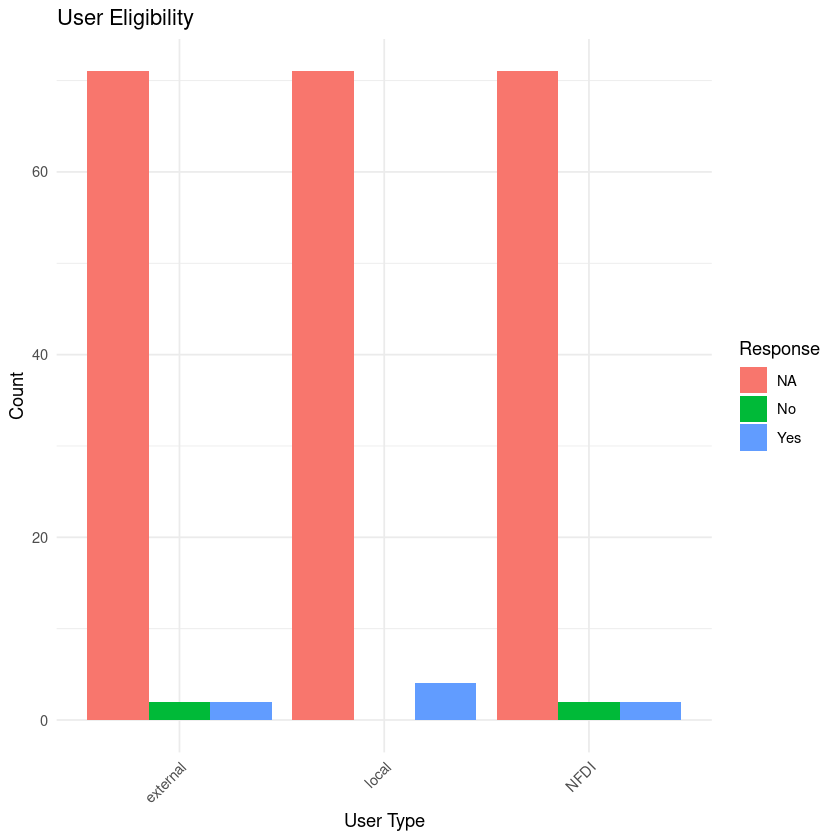

In [52]:
# Create the dodged bar graph
ggplot(eligible_frame_long, aes(x = User, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "User Eligibility",
    x = "User Type",
    y = "Count",
    fill = "Response"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# User Groups in NFDI

In [53]:
# User groups in NFDI
data$user_groups_in_NFDI[!is.na(data$user_groups_in_NFDI)]


[1] "Photon and Neutron community"  "Primarily PAN community users"

# Shared Resources Offer

In [54]:

# Shared resources offer
data$shared_resources_offer[!is.na(data$shared_resources_offer)]


[1] "tbd."     "not suer" "TDB"

# Shared Resources Policies

In [55]:
# shared resources policies
data$shared_resources_policies[!is.na(data$shared_resources_policies)]




[1] "https://mlz-garching.de/englisch/user-office/terms-of-reference.html"
[2] "TDB"

# Expected Benefits from sharing

In [56]:
invisible(capture.output({
table(data$benefits_from_sharing_less_maintenance,useNA = "always")
prop.table(table(data$benefits_from_sharing_less_maintenance,useNA = "always"))*100

table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always")
prop.table(table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always"))*100

table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always")
prop.table(table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always"))*100

table(data$benefits_from_sharing_enhanced_visibility,useNA = "always")
prop.table(table(data$benefits_from_sharing_enhanced_visibility,useNA = "always"))*100

benefits_frame <- rbind.data.frame(table(data$benefits_from_sharing_less_maintenance,useNA = "always"),
                                   table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always"),
                                   table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always"),
                                   table(data$benefits_from_sharing_enhanced_visibility,useNA = "always"))


benefits_frame <- cbind.data.frame(User = c("less_maintenance","focus_on_hardware","centrailized_AAI_user_mngmt","enhanced_visibility"), benefits_frame)
colnames(benefits_frame) <- c("Benefit","Yes","No","NA")

benefits_frame_long <- tidyr::pivot_longer(
  benefits_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

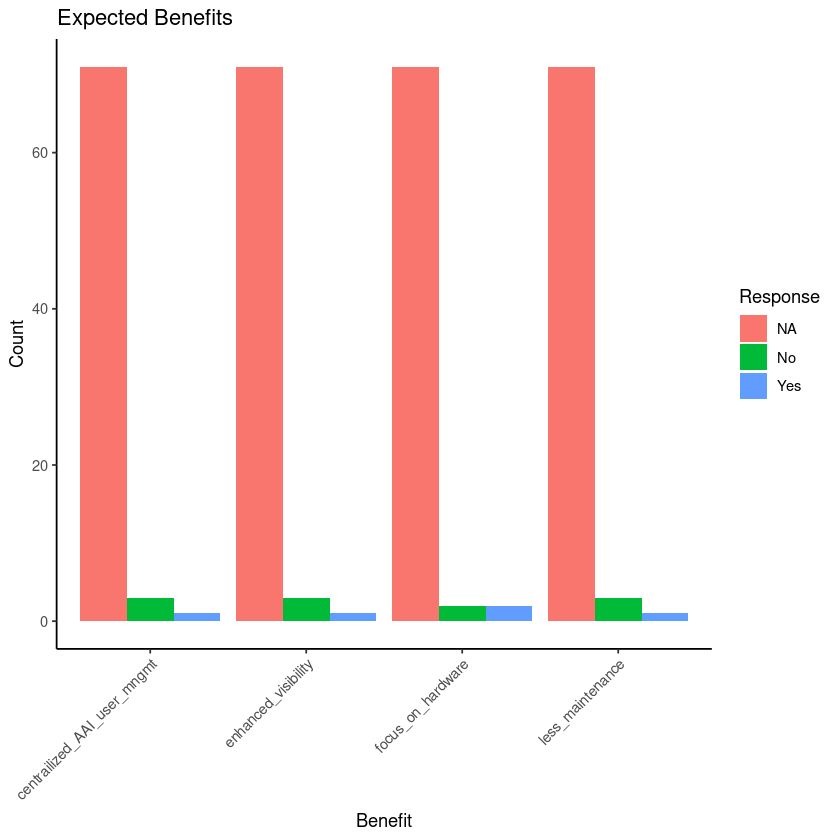

In [57]:
# Create the dodged bar graph
ggplot(benefits_frame_long, aes(x = Benefit, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Expected Benefits",
    x = "Benefit",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Knowing Jupyter

In [58]:
# knowing jupyter
#data$know_jupyter[!is.na(data$know_jupyter)]
#table(data$know_jupyter, useNA = "always")
#prop.table(table(data$know_jupyter, useNA = "always"))*100#

know_jup_frame <- data.frame(table(data$know_jupyter, useNA = "always"))
kable(know_jup_frame)




|Var1 | Freq|
|:----|----:|
|Yes  |    9|
|NA   |   66|

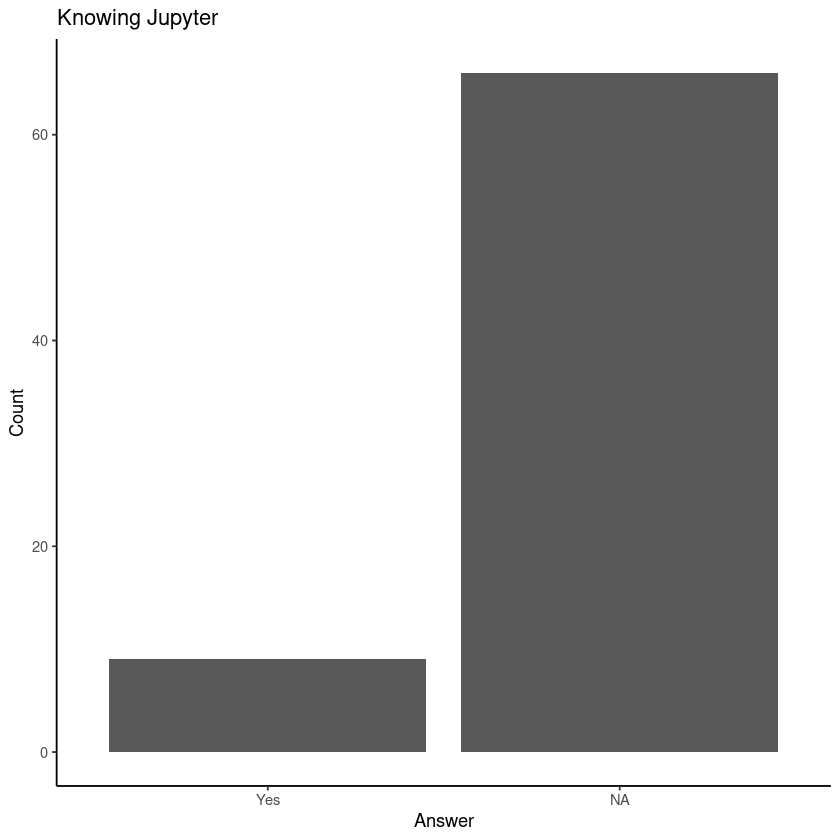

In [59]:
# stacked bar chart
ggplot(data, aes(x = know_jupyter)) + 
  geom_bar() +
  labs(title = "Knowing Jupyter",
       x = "Answer",
       y = "Count") +
  theme_classic()



# Group Size

In [60]:
# group size
data$group_size <- as.numeric(data$group_size)
#fivenum(data$group_size)
summary(data$group_size)


Warning message:
“NAs introduced by coercion”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   6.00    8.50   30.00   44.71   30.00  200.00      68 

Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_summary()`).”


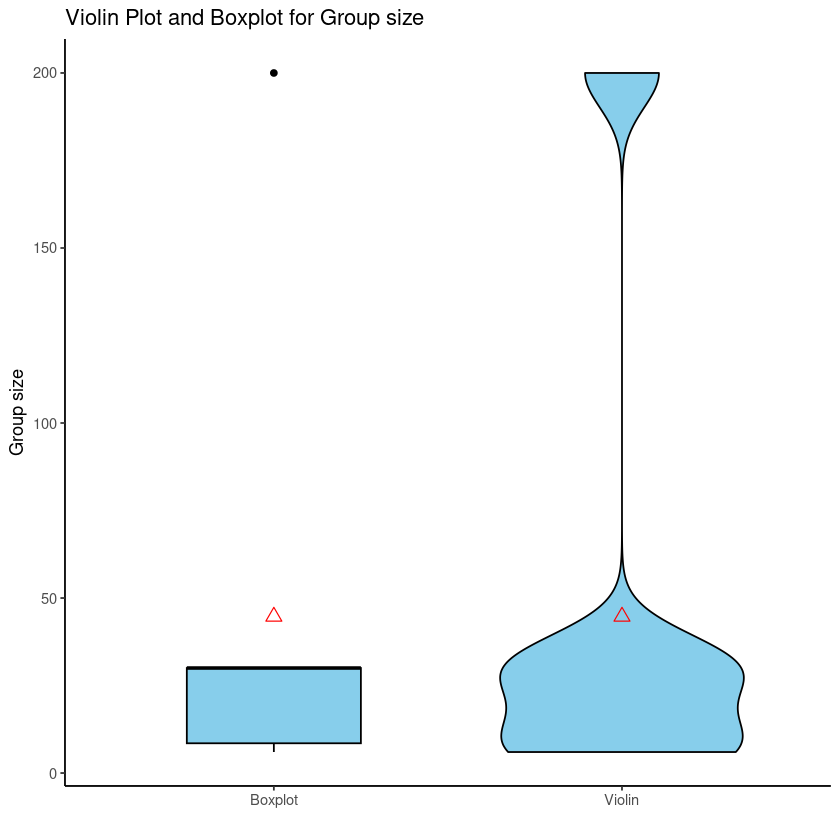

In [61]:
# plot
ggplot(data, aes(x = "Violin", y = group_size)) +
  geom_violin(aes(x = "Violin"), fill = "skyblue", color = "black", width = 0.7) + # Violin
  geom_boxplot(aes(x = "Boxplot"), fill = "skyblue", color = "black", width = 0.5) + # Boxplot
  labs(
    title = "Violin Plot and Boxplot for Group size",
    x = "",
    y = "Group size"
  ) +
  stat_summary(
    aes(x = "Violin"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +
  stat_summary(
    aes(x = "Boxplot"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +# Mean point for violin
  theme_classic()


# Dedicated Partners

In [62]:
# dedicated partners
#data$have_dedicated_partners
dedicated_partner_frame <- data.frame(table(data$have_dedicated_partners,useNA="always"))
kable(dedicated_partner_frame)




|Var1         | Freq|
|:------------|----:|
|I don't know |    1|
|No           |    4|
|Yes          |    4|
|NA           |   66|

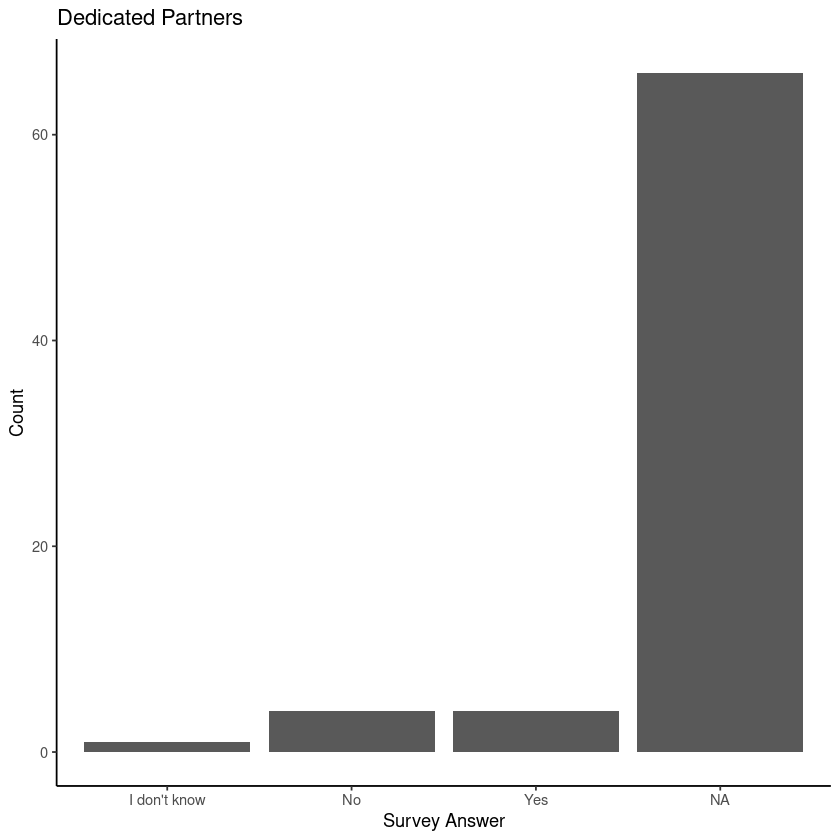

In [63]:
# stacked bar chart
ggplot(data, aes(x = have_dedicated_partners)) + 
  geom_bar() +
  labs(title = "Dedicated Partners",
       x = "Survey Answer",
       y = "Count") +
  theme_classic()



In [64]:
# who is partner
data$partner[!is.na(data$partner)]


[1] "Fraunhofer FOKUS / HLRS"                          
[2] "For Max-Jhub, DESY-IT colleagues are reponsible"  
[3] "Departement of Electrical Engineering at the RPTU"

# Jupyter Purpose

In [65]:
invisible(capture.output({
table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always")
prop.table(table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always"))*100

table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always")
prop.table(table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always"))*100

table(data$jupyter_purpose_whenever_possible,useNA = "always")
prop.table(table(data$jupyter_purpose_whenever_possible,useNA = "always"))*100

table(data$jupyter_purpose_workshops_training,useNA = "always")
prop.table(table(data$jupyter_purpose_workshops_training,useNA = "always"))*100

purpose_frame <- rbind.data.frame(table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always"),
                                   table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always"),
                                   table(data$jupyter_purpose_whenever_possible,useNA = "always"),
                                   table(data$jupyter_purpose_workshops_training,useNA = "always"))


purpose_frame <- cbind.data.frame(User = c("Testing and Tutorials","Heavy Computing and Analysis","Whenever possible","Workshops and Training"), purpose_frame)
colnames(purpose_frame) <- c("Purpose","Yes","No","NA")

purpose_frame_long <- tidyr::pivot_longer(
  purpose_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [66]:
kable(purpose_frame_long)




|Purpose                      |Response | Count|
|:----------------------------|:--------|-----:|
|Testing and Tutorials        |Yes      |     6|
|Testing and Tutorials        |No       |    32|
|Testing and Tutorials        |NA       |    37|
|Heavy Computing and Analysis |Yes      |    18|
|Heavy Computing and Analysis |No       |    20|
|Heavy Computing and Analysis |NA       |    37|
|Whenever possible            |Yes      |    28|
|Whenever possible            |No       |    10|
|Whenever possible            |NA       |    37|
|Workshops and Training       |Yes      |    20|
|Workshops and Training       |No       |    18|
|Workshops and Training       |NA       |    37|

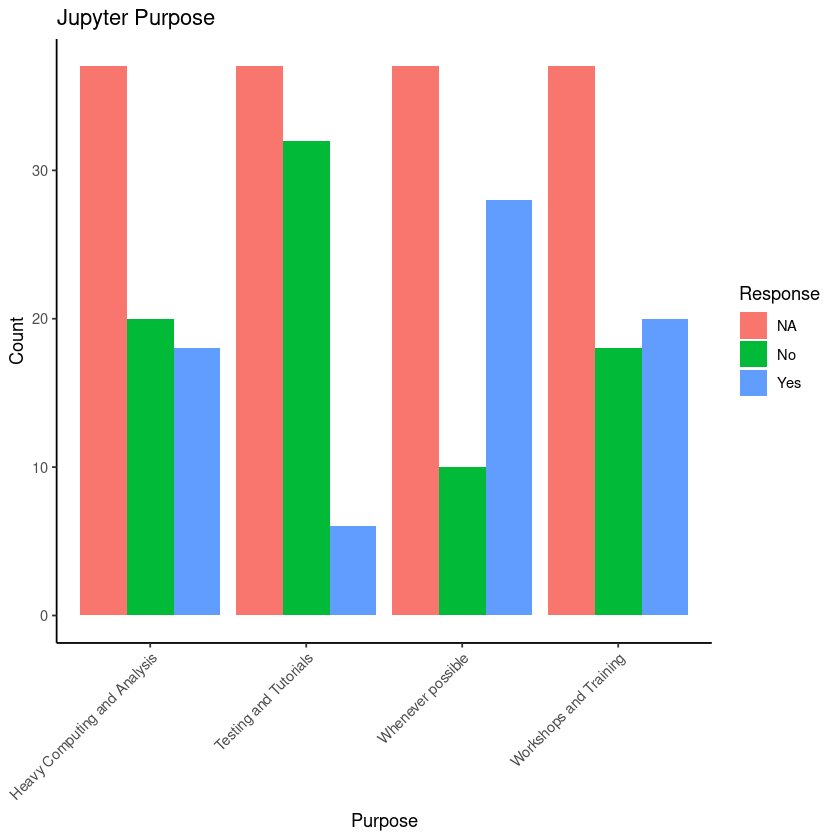

In [67]:
# Create the dodged bar graph
ggplot(purpose_frame_long, aes(x = Purpose, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Jupyter Purpose",
    x = "Purpose",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Other Purposes

In [68]:

data$jupyter_purpose_other[!is.na(data$jupyter_purpose_other)]


[1] "when providing our results to others (the actual software is then wrapped into conda packages)"
[2] "Didn't use it yet"

# Current Jupyter Use

In [69]:
invisible(capture.output({
# current jupyter use
table(data$current_jupyter_use_local,useNA = "always")
prop.table(table(data$current_jupyter_use_local,useNA = "always"))*100

table(data$current_jupyter_use_remote,useNA = "always")
prop.table(table(data$current_jupyter_use_remote,useNA = "always"))*100

table(data$current_jupyter_use_jupyterlite,useNA = "always")
prop.table(table(data$current_jupyter_use_jupyterlite,useNA = "always"))*100

table(data$current_jupyter_use_colab,useNA = "always")
prop.table(table(data$current_jupyter_use_colab,useNA = "always"))*100

current_use_frame <- rbind.data.frame(table(data$current_jupyter_use_local,useNA = "always"),
                                  table(data$current_jupyter_use_remote,useNA = "always"),
                                  table(data$current_jupyter_use_jupyterlite,useNA = "always"),
                                  table(data$current_jupyter_use_colab,useNA = "always"))


current_use_frame <- cbind.data.frame(User = c("Local","Remote","Jupyterlite","Colab"), current_use_frame)
colnames(current_use_frame) <- c("Current Use","Yes","No","NA")

current_use_frame_long <- tidyr::pivot_longer(
  current_use_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [70]:
kable(current_use_frame_long)




|Current Use |Response | Count|
|:-----------|:--------|-----:|
|Local       |Yes      |     9|
|Local       |No       |    29|
|Local       |NA       |    37|
|Remote      |Yes      |    20|
|Remote      |No       |    18|
|Remote      |NA       |    37|
|Jupyterlite |Yes      |    37|
|Jupyterlite |No       |     1|
|Jupyterlite |NA       |    37|
|Colab       |Yes      |    26|
|Colab       |No       |    12|
|Colab       |NA       |    37|

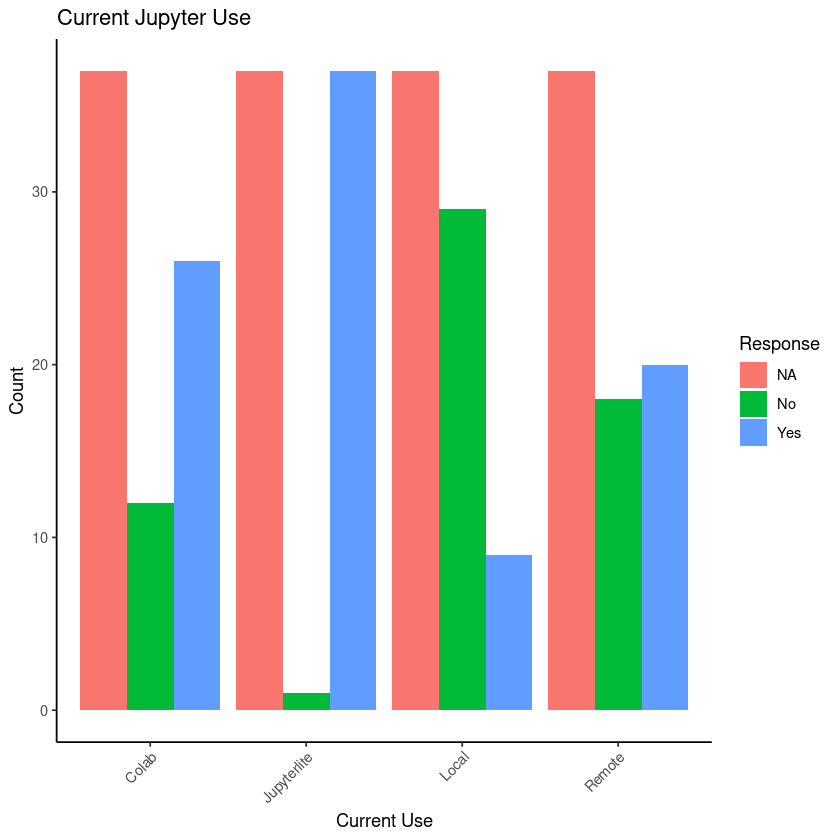

In [71]:

# Create the dodged bar graph
ggplot(current_use_frame_long, aes(x = `Current Use`, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Current Jupyter Use",
    x = "Current Use",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Other current use

In [72]:
data$current_jupyter_use_other[!is.na(data$current_jupyter_use_other)]


[1] "jupyterlab on remote virtual  machine s in a cloud"
[2] "Galaxy"                                            
[3] "cocalc"

# Jupyter Provider

In [73]:
# Jupyter Provider
data$jupyter_provider_who[!is.na(data$jupyter_provider_who)]


[1] "Bochum University of Applied Sciences"                         
 [2] "University Muenster, soon jupyterhub.nrw"                      
 [3] "Biender"                                                       
 [4] "Universität Stuttgart"                                         
 [5] "The Physik department at LMU"                                  
 [6] "Wikimedia Foundation"                                          
 [7] "RWTH Aachen University"                                        
 [8] "don't know"                                                    
 [9] "Computing Center of Technische Universität Darmstadt"          
[10] "DESY"                                                          
[11] "AIP, selfhosted"                                               
[12] "The research department where I am employed"                   
[13] "bwJupyterHub"                                                  
[14] "self hosted for research, Academic Cloud for teaching/students"
[15] "bwHPC, SCCKN, Self-Hosted"                                     
[16] "Univ Münster"

# Resource Requirements

In [74]:
invisible(capture.output({
# Resource Requirements
table(data$resource_requirements_concurrenct_session_average,useNA = "always")
prop.table(table(data$resource_requirements_concurrenct_session_average,useNA = "always"))*100

table(data$resource_requirements_concurrent_session_peak,useNA = "always")
prop.table(table(data$resource_requirements_concurrent_session_peak,useNA = "always"))*100

table(data$resource_requirements_user_number,useNA = "always")
prop.table(table(data$resource_requirements_user_number,useNA = "always"))*100

table(data$resource_requirements_gpus_per_session,useNA = "always")
prop.table(table(data$resource_requirements_gpus_per_session,useNA = "always"))*100

table(data$resource_requirements_cpus_per_session,useNA = "always")
prop.table(table(data$resource_requirements_cpus_per_session,useNA = "always"))*100

table(data$resource_requirements_ram_per_session,useNA = "always")
prop.table(table(data$resource_requirements_ram_per_session,useNA = "always"))*100

table(data$resource_requirements_persistent_storage_per_session,useNA = "always")
prop.table(table(data$resource_requirements_persistent_storage_per_session,useNA = "always"))*100

requirements_frame <- rbind.data.frame(table(data$resource_requirements_concurrenct_session_average,useNA = "always"),
                                      table(data$resource_requirements_concurrent_session_peak,useNA = "always"),
                                      table(data$resource_requirements_user_number,useNA = "always"),
                                      table(data$resource_requirements_gpus_per_session,useNA = "always"),
                                      table(data$resource_requirements_cpus_per_session,useNA = "always"),
                                      table(data$resource_requirements_ram_per_session,useNA = "always"),
                                      table(data$resource_requirements_persistent_storage_per_session,useNA = "always"))


requirements_frame <- cbind.data.frame(User = c("Concurrent Session Average","Concurrent Session Peak","User Number","GPUs per Session","CPUS per Session","RAM per Session","Persistent Storage per Session"), requirements_frame)
colnames(requirements_frame) <- c("Requirement","Yes","No","NA")

requirements_frame_long <- tidyr::pivot_longer(
  requirements_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)


}))

In [75]:
kable(requirements_frame_long)




|Requirement                    |Response | Count|
|:------------------------------|:--------|-----:|
|Concurrent Session Average     |Yes      |    23|
|Concurrent Session Average     |No       |    15|
|Concurrent Session Average     |NA       |    37|
|Concurrent Session Peak        |Yes      |    24|
|Concurrent Session Peak        |No       |    14|
|Concurrent Session Peak        |NA       |    37|
|User Number                    |Yes      |    25|
|User Number                    |No       |    13|
|User Number                    |NA       |    37|
|GPUs per Session               |Yes      |    26|
|GPUs per Session               |No       |    12|
|GPUs per Session               |NA       |    37|
|CPUS per Session               |Yes      |    26|
|CPUS per Session               |No       |    12|
|CPUS per Session               |NA       |    37|
|RAM per Session                |Yes      |    24|
|RAM per Session                |No       |    14|
|RAM per Session             

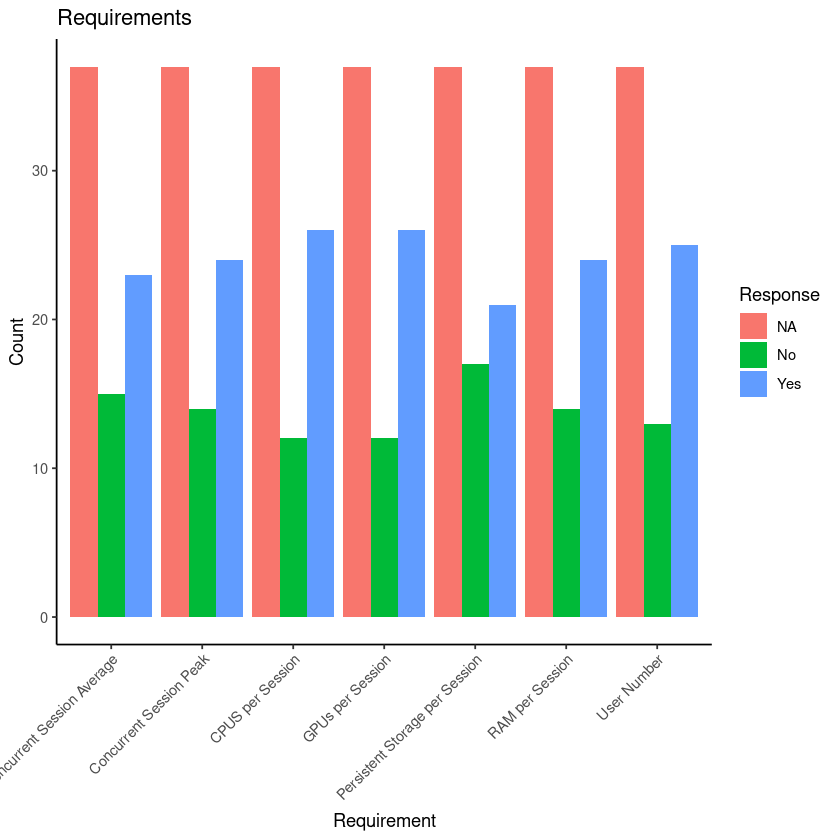

In [76]:
# Create the dodged bar graph
ggplot(requirements_frame_long, aes(x = Requirement, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Requirements",
    x = "Requirement",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Requirement Comments

In [77]:
invisible(capture.output({
resource_requirements_concurrenct_session_average_comment <- as.numeric(data$resource_requirements_concurrenct_session_average_comment)
resource_requirements_concurrent_session_peak_comment <- as.numeric(data$resource_requirements_concurrent_session_peak_comment)
resource_requirements_user_number_comment <- as.numeric(data$resource_requirements_user_number_comment)
resource_requirements_gpus_per_session_comment <- as.numeric(data$resource_requirements_gpus_per_session_comment)
resource_requirements_cpus_per_session_comment <- as.numeric(data$resource_requirements_cpus_per_session_comment)
resource_requirements_ram_per_session_comment <- as.numeric(data$resource_requirements_ram_per_session_comment)
resource_requirements_persistent_storage_per_session_comment <- as.numeric(data$resource_requirements_persistent_storage_per_session_comment)

resource_frame <- cbind.data.frame(resource_requirements_concurrenct_session_average_comment,
                                   resource_requirements_concurrent_session_peak_comment,
                                   resource_requirements_user_number_comment,
                                   resource_requirements_gpus_per_session_comment,
                                   resource_requirements_cpus_per_session_comment,
                                   resource_requirements_ram_per_session_comment,
                                   resource_requirements_persistent_storage_per_session_comment
                                   )


}))

Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    2.00    2.00   26.85   10.00  200.00      62 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 62 rows containing non-finite outside the scale range (`stat_bin()`).”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    5.00   20.00   65.69   30.00  300.00      62 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 62 rows containing non-finite outside the scale range (`stat_bin()`).”


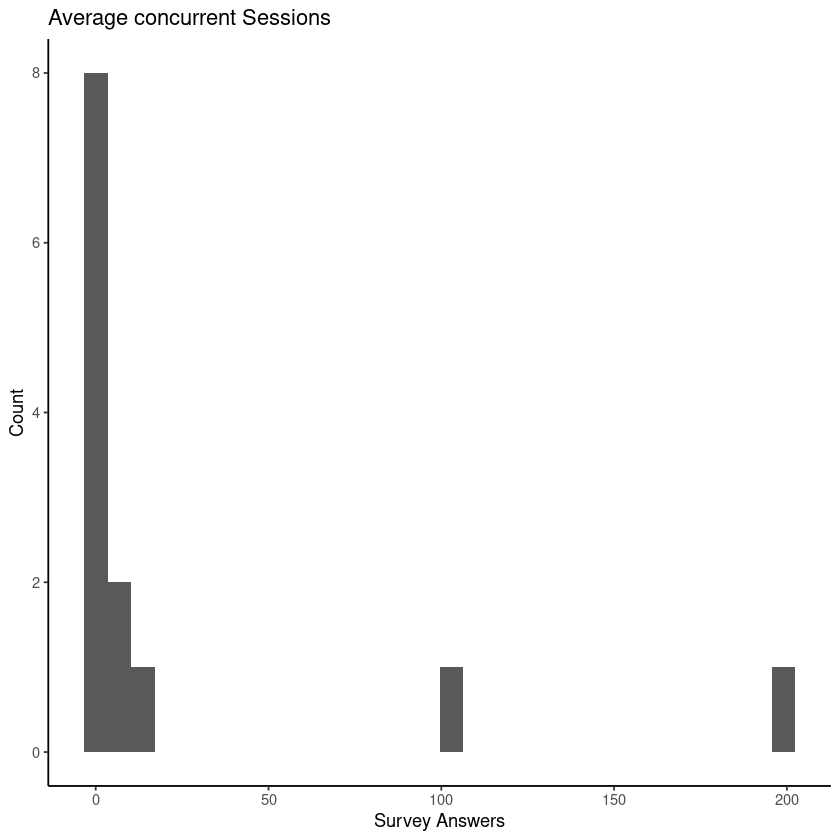

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    1.00    5.00   25.09   15.00  200.00      64 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 64 rows containing non-finite outside the scale range (`stat_bin()`).”


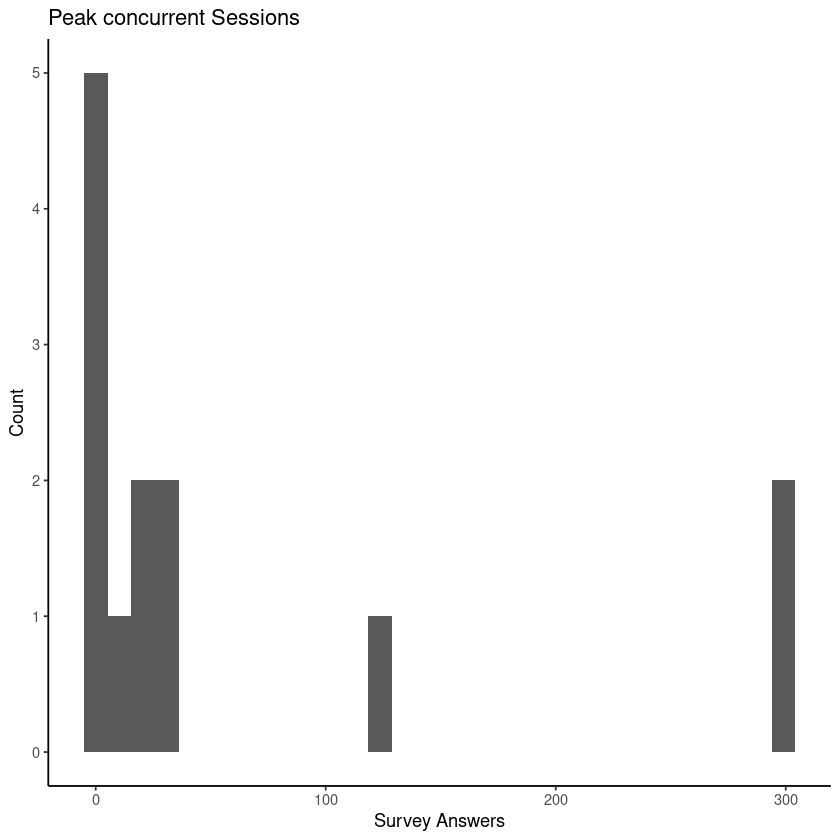

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.00    1.00   29.33    1.00  256.00      66 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 66 rows containing non-finite outside the scale range (`stat_bin()`).”


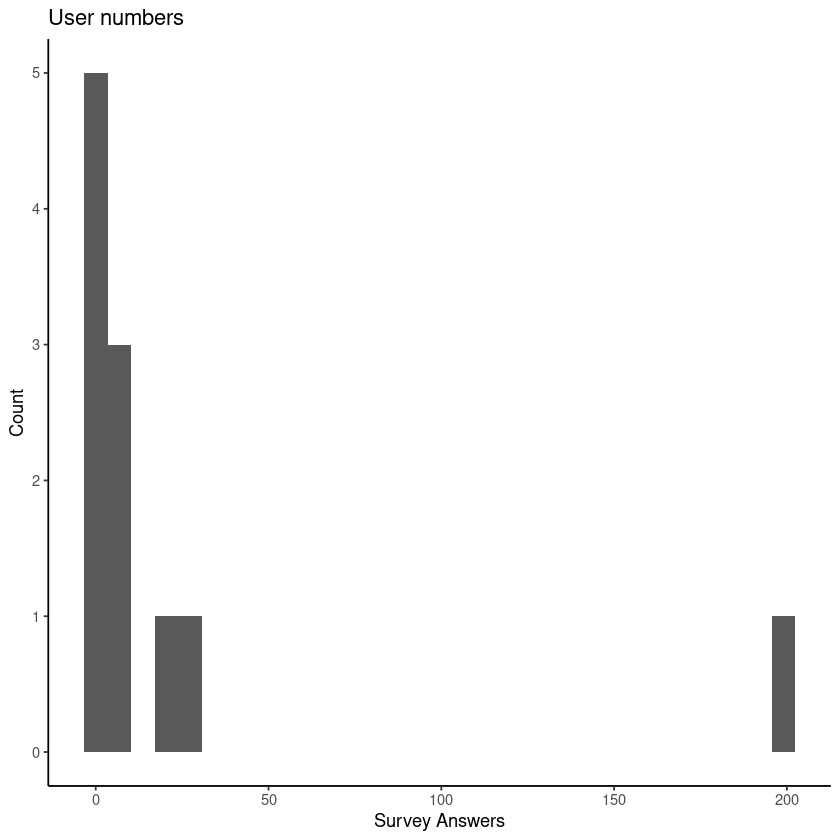

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   2.000   7.444   8.000  32.000      66 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 66 rows containing non-finite outside the scale range (`stat_bin()`).”


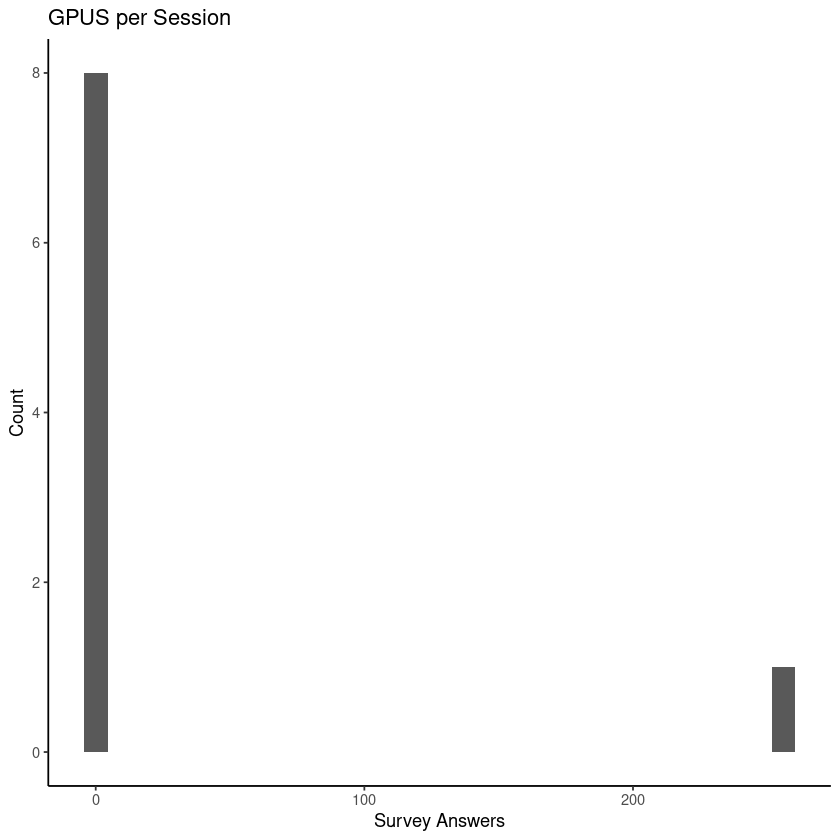

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    4.0     8.0    16.0   197.5    20.0  2000.0      64 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 64 rows containing non-finite outside the scale range (`stat_bin()`).”


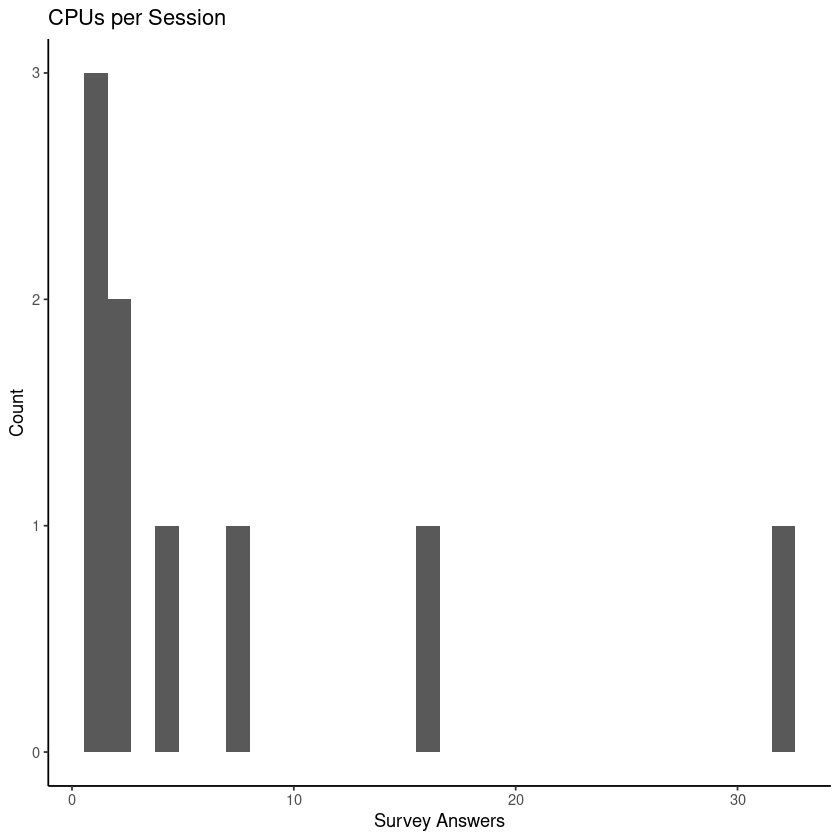

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    5.0    17.5    40.0   200.0    52.5  2000.0      63 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 63 rows containing non-finite outside the scale range (`stat_bin()`).”


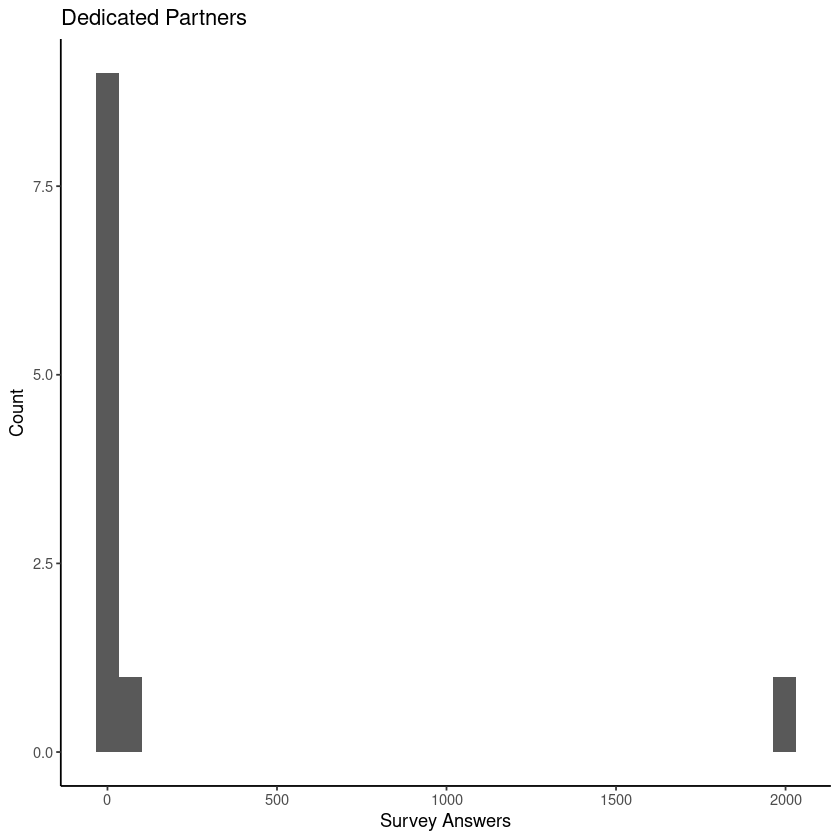

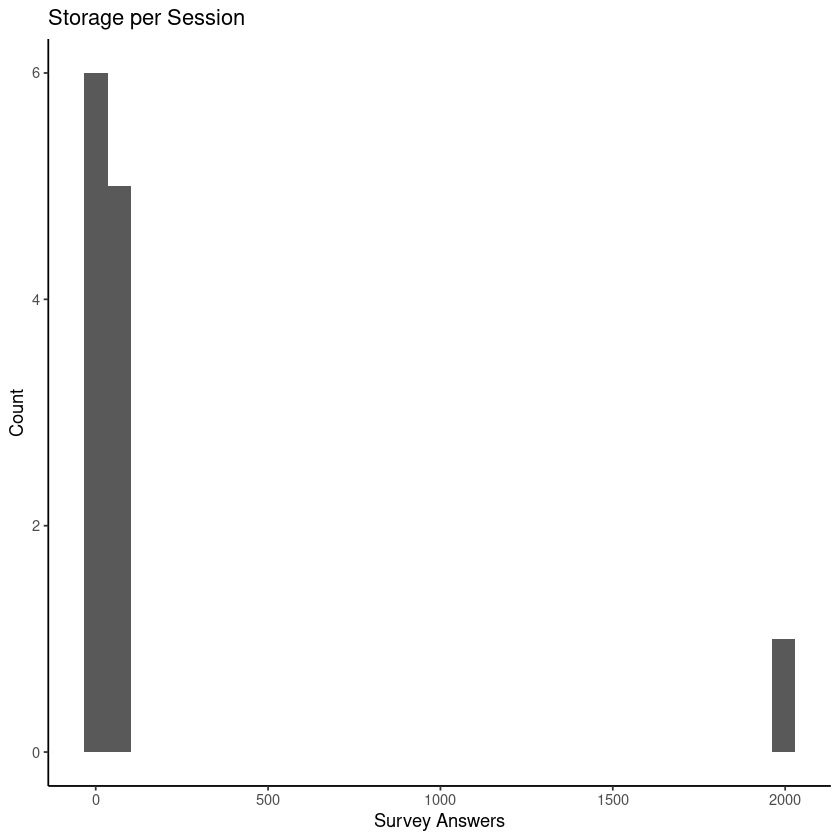

In [111]:
# geom_boxplot
summary(resource_frame$resource_requirements_concurrenct_session_average_comment)
ggplot(resource_frame, aes(x = resource_requirements_concurrenct_session_average_comment)) + 
  geom_histogram() +
  labs(title = "Average concurrent Sessions",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_concurrent_session_peak_comment)
ggplot(resource_frame, aes(x = resource_requirements_concurrent_session_peak_comment)) + 
  geom_histogram() +
  labs(title = "Peak concurrent Sessions",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_user_number_comment)
ggplot(resource_frame, aes(x = resource_requirements_user_number_comment)) + 
  geom_histogram() +
  labs(title = "User numbers",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_gpus_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_gpus_per_session_comment)) + 
  geom_histogram() +
  labs(title = "GPUS per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# sgeom_boxplot
summary(resource_frame$resource_requirements_cpus_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_cpus_per_session_comment)) + 
  geom_histogram() +
  labs(title = "CPUs per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_ram_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_ram_per_session_comment)) + 
  geom_histogram() +
  labs(title = "Dedicated Partners",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_persistent_storage_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_persistent_storage_per_session_comment)) + 
  geom_histogram() +
  labs(title = "Storage per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# Environment Requirements

In [79]:
invisible(capture.output({
table(data$env_requirements_lab_extension,useNA = "always")
prop.table(table(data$env_requirements_lab_extension,useNA = "always"))*100

table(data$env_requirements_software,useNA = "always")
prop.table(table(data$env_requirements_software,useNA = "always"))*100

table(data$env_requirements_licenses,useNA = "always")
prop.table(table(data$env_requirements_licenses,useNA = "always"))*100

table(data$env_requirements_custom_images,useNA = "always")
prop.table(table(data$env_requirements_custom_images,useNA = "always"))*100

env_requirements_frame <- rbind.data.frame(table(data$env_requirements_lab_extension,useNA = "always"),
                                       table(data$env_requirements_software,useNA = "always"),
                                       table(data$env_requirements_licenses,useNA = "always"),
                                       table(data$env_requirements_custom_images,useNA = "always"))


env_requirements_frame <- cbind.data.frame(User = c("Lab Extension","Software","Licenses","Custom Images"), env_requirements_frame)
colnames(env_requirements_frame) <- c("Env Requirement","Yes","No","NA")

env_requirements_frame_long <- tidyr::pivot_longer(
  env_requirements_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)



}))

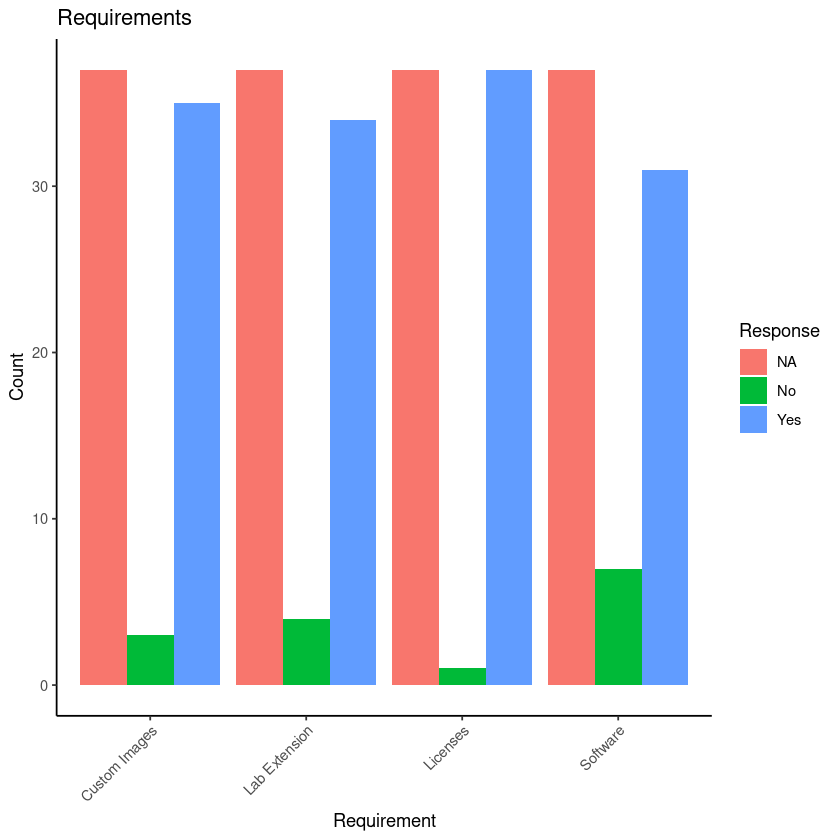

In [80]:
# Create the dodged bar graph
ggplot(env_requirements_frame_long, aes(x = `Env Requirement`, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Requirements",
    x = "Requirement",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [81]:
# env reqs comments
data$env_requirements_lab_extension_comment[!is.na(data$env_requirements_lab_extension_comment)]
data$env_requirements_software_comment[!is.na(data$env_requirements_software_comment)]
data$env_requirements_licenses_comment[!is.na(data$env_requirements_licenses_comment)]
data$env_requirements_custom_images_comment[!is.na(data$env_requirements_custom_images_comment)]


[1] "3"                                                                    
[2] "unsure"                                                               
[3] "interconnection with learning management software (Moodle); nb-grader"
[4] "dask, panel"

[1] "conda with the option to provide own environments"  
[2] "Python (with various python tools getting imported)"
[3] "cuda/gpu/opengl"                                    
[4] "PyPSA, pandapower"                                  
[5] "All kinds of python packes, also self written ones" 
[6] "Pandas, Matplotlib, Scikit-Learn, Tensorflow"

[1] "OSI-approved"

[1] "Python, TensorFlow, PyTorch, CellProfiler, Cellpose, OMERO, Fiji, napari, StarDist, QuPath"
[2] "hosted at gitlab-p4n.aip.de"

# External Data Access

In [82]:
# External data access
kable(data.frame(table(data$external_data_access,useNA = "always")))




|Var1            | Freq|
|:---------------|----:|
|I dont know yet |    8|
|No              |    3|
|Yes             |   27|
|NA              |   37|

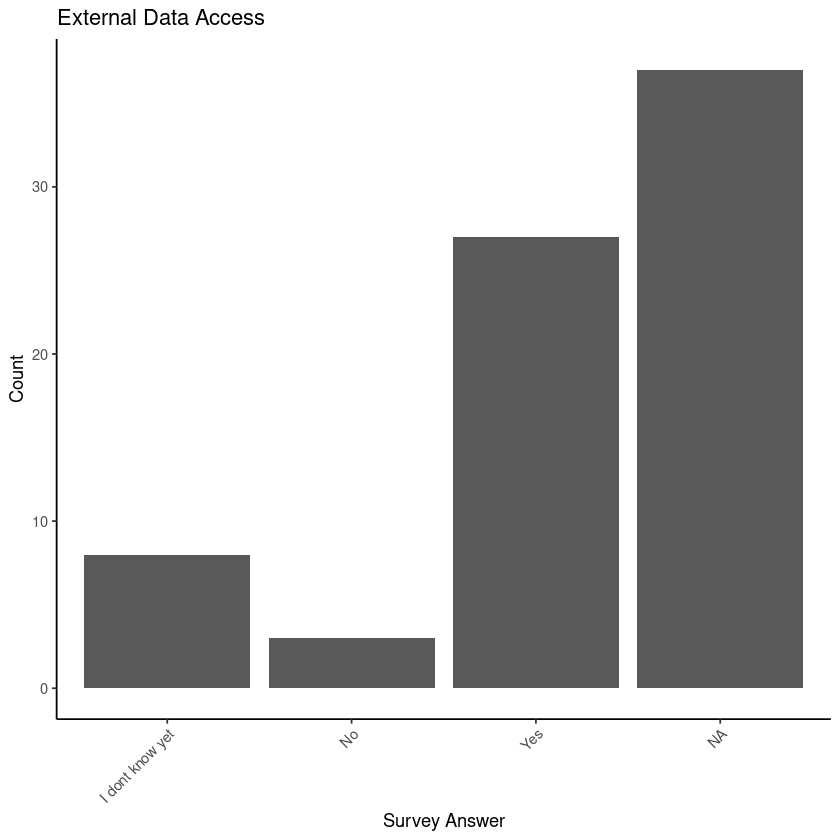

In [83]:
# stacked bar chart
ggplot(data, aes(x = external_data_access)) + 
  geom_bar() +
  labs(title = "External Data Access",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [84]:
# write access
kable(data.frame(table(data$write_access_to_shared_data,useNA="always")))




|Var1            | Freq|
|:---------------|----:|
|I dont know yet |    7|
|No              |    6|
|Yes             |   14|
|NA              |   48|

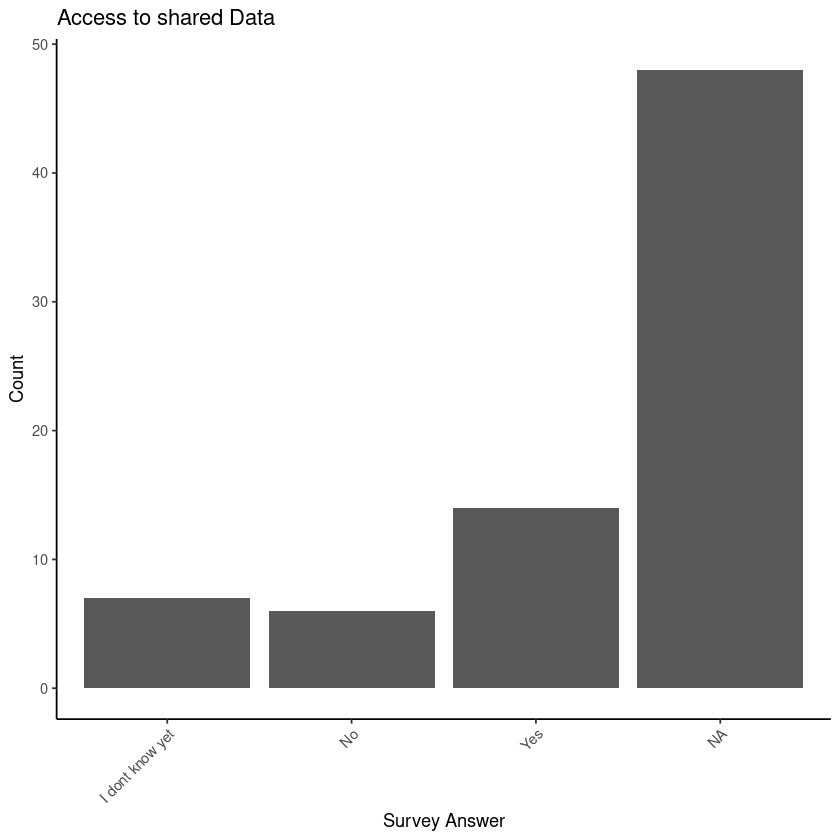

In [85]:
# stacked bar chart
ggplot(data, aes(x = write_access_to_shared_data)) + 
  geom_bar() +
  labs(title = "Access to shared Data",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [86]:
# external_data_sources_link
data$external_data_sources_link[!is.na(data$external_data_sources_link)]


[1] "external triple store (RDF) and file server to query benchmarks input files and store results"
 [2] "This varies a lot."                                                                           
 [3] "https://github.com/echemdb/electrochemistry-data"                                             
 [4] "unsure"                                                                                       
 [5] "data repositories: Zenodo; institutional repository"                                          
 [6] "Raw data from the neutron and X-ray large scale research facilities"                          
 [7] "various HPC data systems"                                                                     
 [8] "local GitLab instance"                                                                        
 [9] "Import from Chemotion would be nice"                                                          
[10] "OpenStack Swift (S3)"                                                                         
[11] "Github"

# Service Offer through Platform

In [87]:
# sservice offer through platform
kable(data.frame(table(data$offer_software_service_through_platform,useNA="always")))




|Var1            | Freq|
|:---------------|----:|
|I dont know yet |   18|
|No              |   11|
|Yes             |    9|
|NA              |   37|

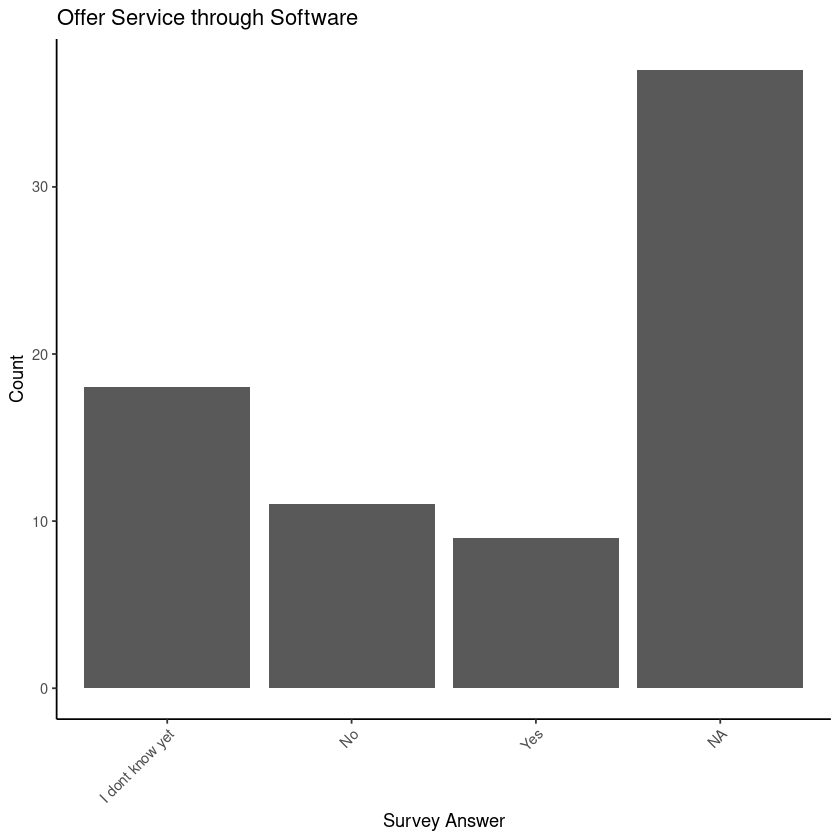

In [88]:

# stacked bar chart
ggplot(data, aes(x = offer_software_service_through_platform)) + 
  geom_bar() +
  labs(title = "Offer Service through Software",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [89]:
# which software service offer
data$which_software_service_offer[!is.na(data$which_software_service_offer)]

[1] "providing benchmark results to other users, compute the benchmarks, and provide parameterized simulation tools to others (such that they can run our models on a platform without to install anything themselves)"
[2] "Public training courses on Python usage and data evaluation"                                                                                                                                                      
[3] "LLMs"                                                                                                                                                                                                             
[4] "Analysis Workflows, open to the public."                                                                                                                                                                          
[5] "training service, eventually user support / consulting service"

Knowing Binder

In [90]:
# Knowing Binder
kable(data.frame(table(data$know_binder,useNA="always")))




|Var1                                             | Freq|
|:------------------------------------------------|----:|
|I already use it                                 |    8|
|I know it and potentially need the functionality |   10|
|I know it but don’t need the functionality       |    2|
|Never heard                                      |   18|
|NA                                               |   37|

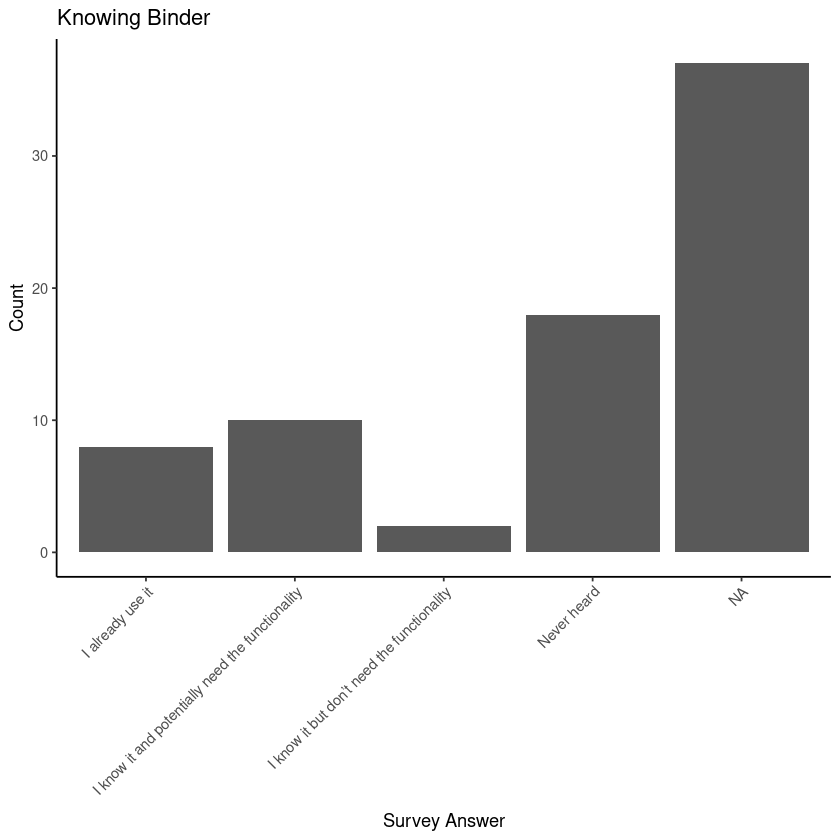

In [91]:

# stacked bar chart
ggplot(data, aes(x = know_binder)) + 
  geom_bar() +
  labs(title = "Knowing Binder",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Reproducibility needed

In [92]:
kable(data.frame(table(data$reproducibility_needed, useNA = "always")))




|Var1            | Freq|
|:---------------|----:|
|I dont know yet |   11|
|No              |    3|
|Yes             |   24|
|NA              |   37|

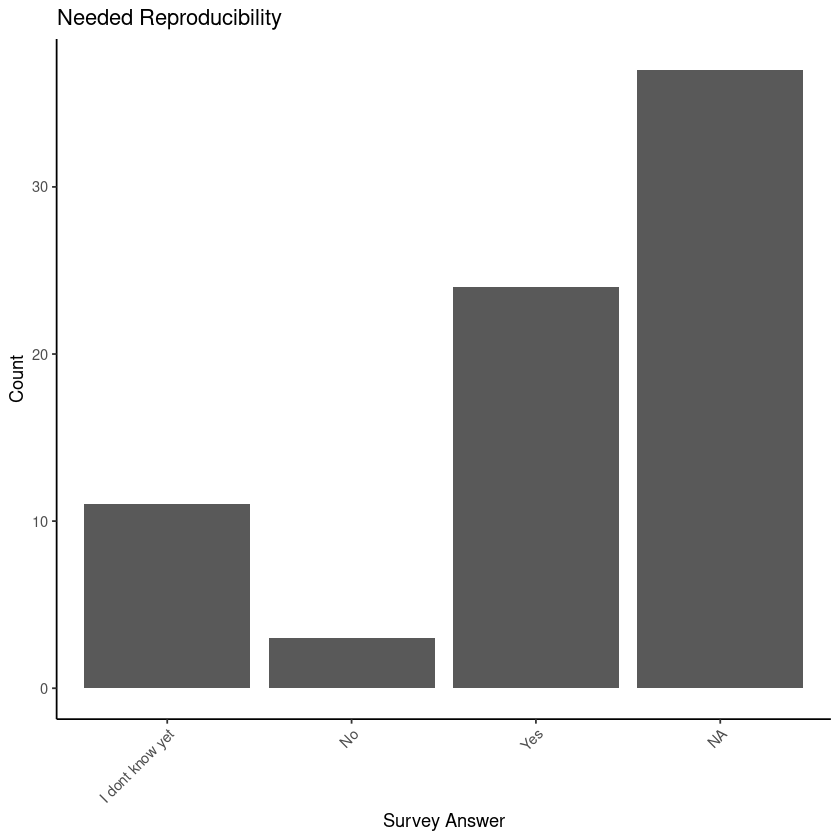

In [93]:

# stacked bar chart
ggplot(data, aes(x = reproducibility_needed)) + 
  geom_bar() +
  labs(title = "Needed Reproducibility",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Knowing Jupyterlite

In [94]:
# knowing jupyterlite
kable(data.frame(table(data$know_jupyterlite, useNA = "always")))



|Var1                                             | Freq|
|:------------------------------------------------|----:|
|I already use it                                 |    3|
|I know it and potentially need the functionality |    7|
|I know it but don’t need the functionality       |    3|
|Never heard                                      |   25|
|NA                                               |   37|

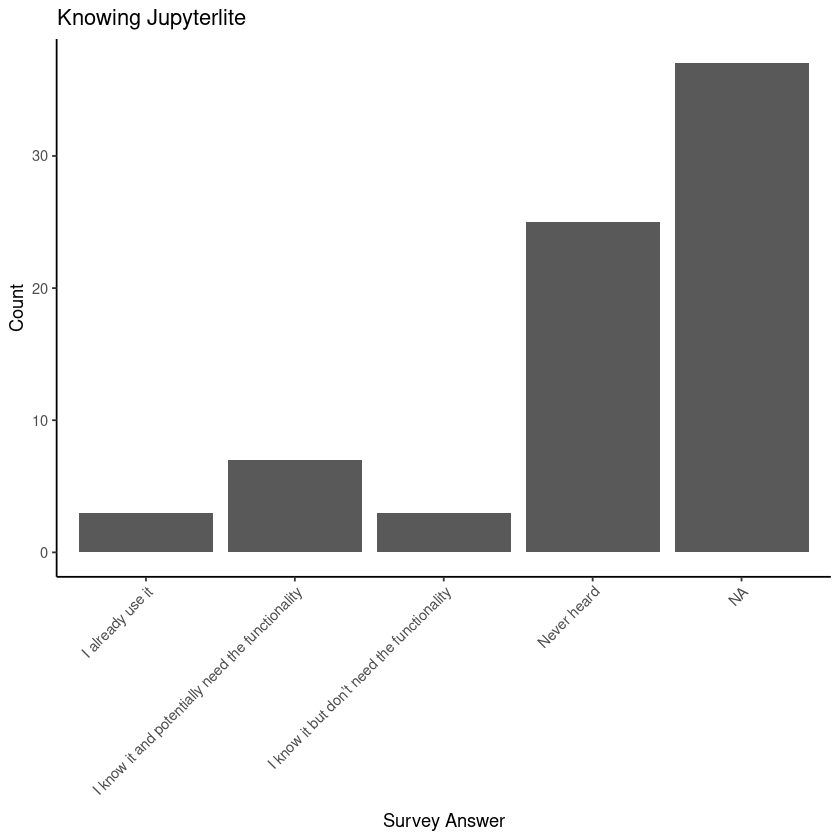

In [95]:
# stacked bar chart
ggplot(data, aes(x = know_jupyterlite)) + 
  geom_bar() +
  labs(title = "Knowing Jupyterlite",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Knowing Google Colab

In [96]:
# knowing Colab
kable(data.frame(table(data$know_colab, useNA = "always")))




|Var1                                             | Freq|
|:------------------------------------------------|----:|
|I already use it                                 |   14|
|I know it and potentially need the functionality |   12|
|I know it but don’t need the functionality       |    5|
|Never heard                                      |    7|
|NA                                               |   37|

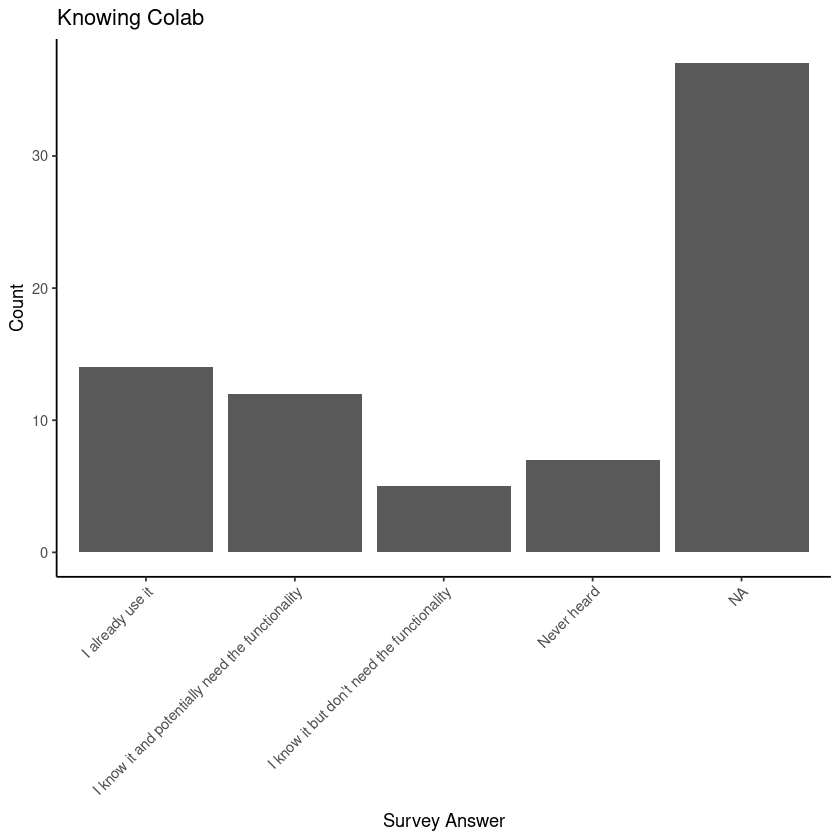

In [97]:

# stacked bar chart
ggplot(data, aes(x = know_colab)) + 
  geom_bar() +
  labs(title = "Knowing Colab",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Interest in other Services

In [98]:
table(data$interest_in_other_service_vscode,useNA = "always")
prop.table(table(data$interest_in_other_service_vscode,useNA = "always"))*100

table(data$interest_in_other_service_rstudio,useNA = "always")
prop.table(table(data$interest_in_other_service_rstudio,useNA = "always"))*100

other_interest_frame <- rbind.data.frame(table(data$interest_in_other_service_vscode,useNA = "always"),
                                           table(data$interest_in_other_service_rstudio,useNA = "always"))


other_interest_frame <- cbind.data.frame(Service = c("VScode","RStudio"), other_interest_frame)
colnames(other_interest_frame) <- c("Service","Yes","No","NA")

other_interest_frame_long <- tidyr::pivot_longer(
  other_interest_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)



  No  Yes <NA> 
  12   26   37 


      No      Yes     <NA> 
16.00000 34.66667 49.33333 


  No  Yes <NA> 
  34    4   37 


       No       Yes      <NA> 
45.333333  5.333333 49.333333 

In [99]:
kable(other_interest_frame_long)




|Service |Response | Count|
|:-------|:--------|-----:|
|VScode  |Yes      |    12|
|VScode  |No       |    26|
|VScode  |NA       |    37|
|RStudio |Yes      |    34|
|RStudio |No       |     4|
|RStudio |NA       |    37|

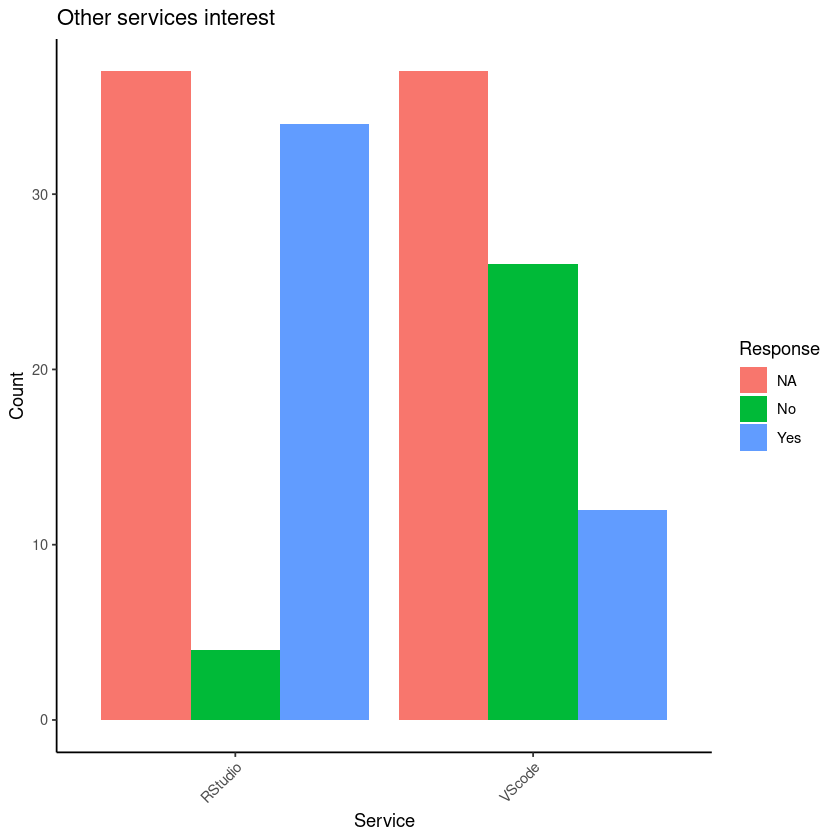

In [100]:
# Create the dodged bar graph
ggplot(other_interest_frame_long, aes(x = Service, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Other services interest",
    x = "Service",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [101]:
# Other service interest
data$interest_in_other_service_other[!is.na(data$interest_in_other_service_other)]

[1] "MATLAB"     "test"       "JupyterLab" "xpre"

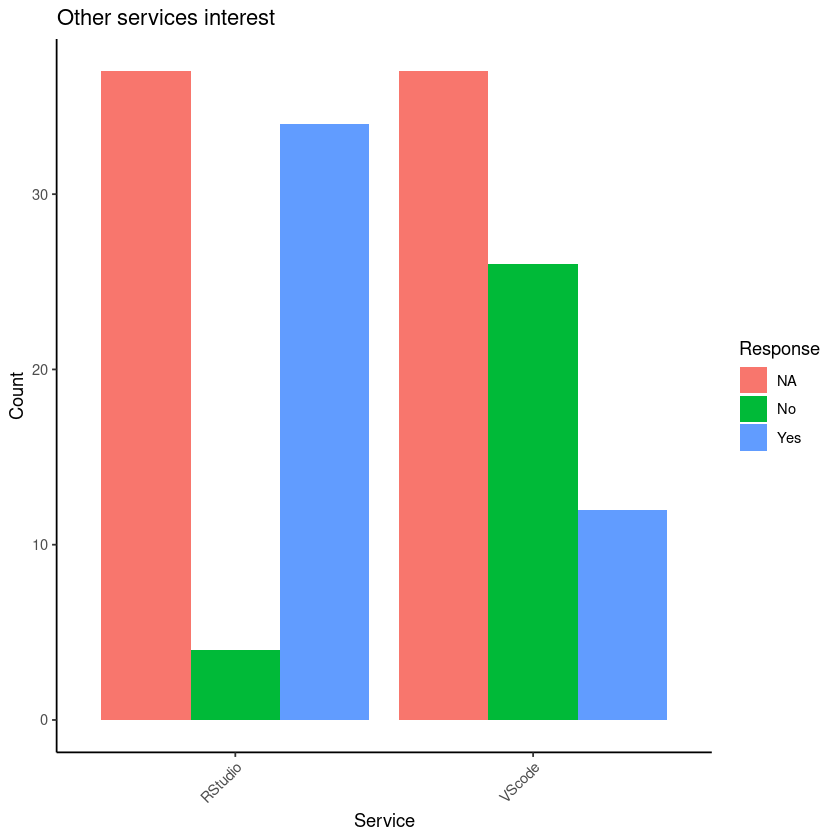

In [102]:

# Create the dodged bar graph
ggplot(other_interest_frame_long, aes(x = Service, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Other services interest",
    x = "Service",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Further Contact

In [103]:
# further contact
#data$further_contact
#table(data$further_contact,useNA = "always")
#prop.table(table(data$further_contact,useNA = "always"))*100

kable(data.frame(table(data$further_contact,useNA = "always")))



|Var1 | Freq|
|:----|----:|
|No   |   22|
|Yes  |   35|
|NA   |   18|

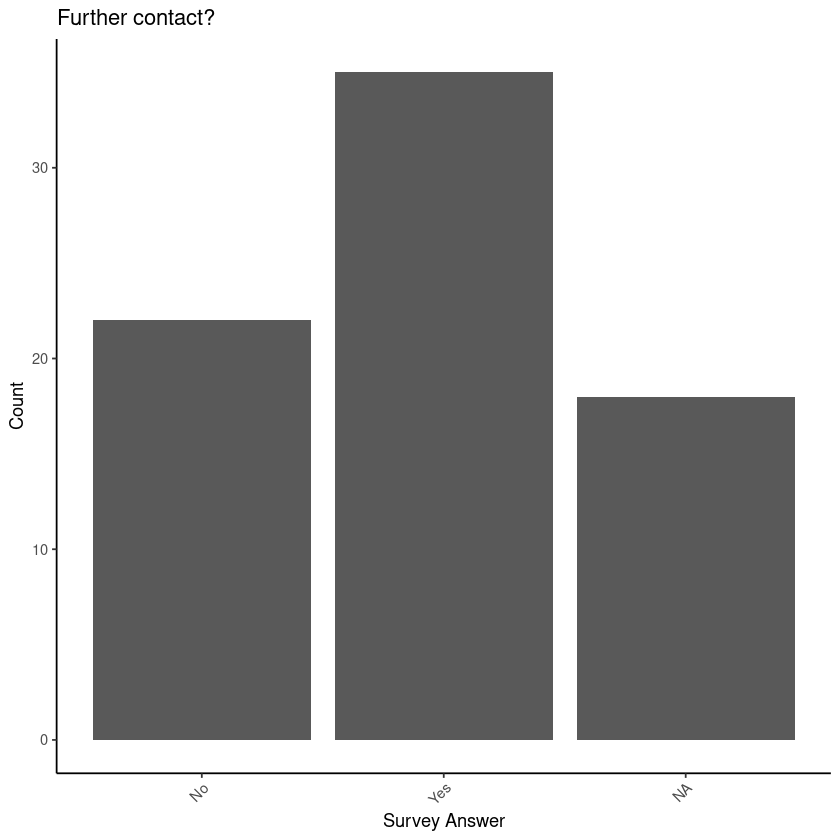

In [104]:

# stacked bar chart
ggplot(data, aes(x = further_contact)) + 
  geom_bar() +
  labs(title = "Further contact?",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# User Study Willingness

In [105]:
# user study willingness
#data$user_study_willingness
#table(data$user_study_willingness,useNA = "always")
#prop.table(table(data$user_study_willingness,useNA = "always"))*100

kable(data.frame(table(data$user_study_willingness,useNA = "always")))




|Var1 | Freq|
|:----|----:|
|No   |    4|
|Yes  |   23|
|NA   |   48|

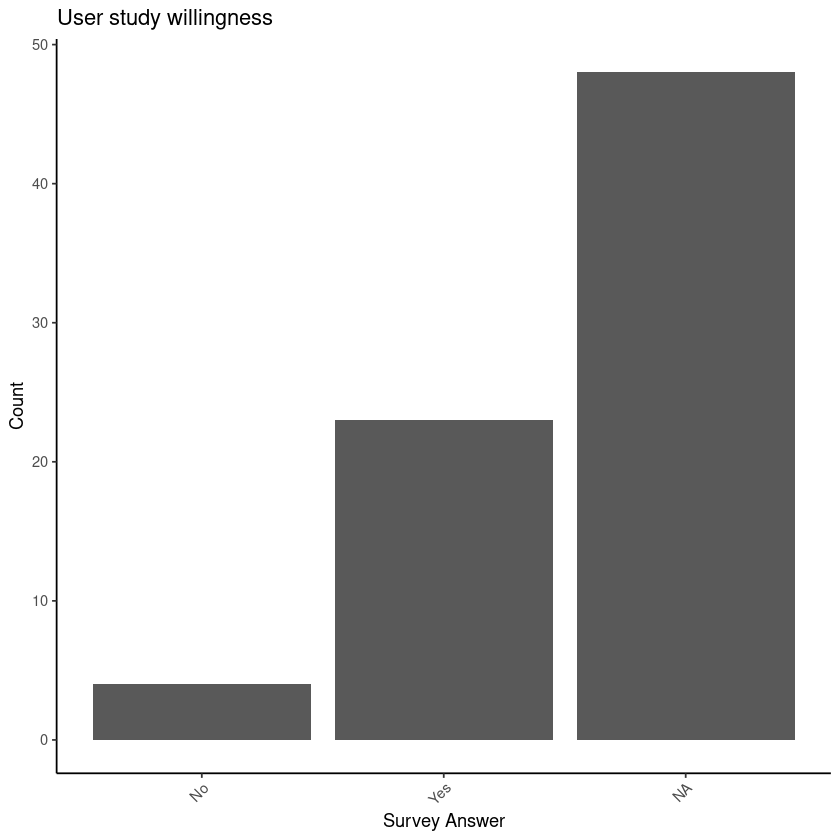

In [106]:
# stacked bar chart
ggplot(data, aes(x = user_study_willingness)) + 
  geom_bar() +
  labs(title = "User study willingness",
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Open ended Questions
[API KEY REQUIRED]

In [107]:
# TODO: To execute remotely, replace with your own API key for chatGPT
api_key <- Sys.getenv("OPENAI_API_KEY")

In [108]:
send_chatgpt_request <- function(prompt, api_key, max_toks = 5000, temp = 0.0) {
  url <- "https://api.openai.com/v1/chat/completions"
  
  headers <- add_headers(
    `Authorization` = paste("Bearer", api_key),
    `Content-Type` = "application/json"
  )
  
  body <- list(
    model = "gpt-4o", 
    messages = list(
      list(role = "system", content = "You are a helpful assistant."),
      list(role = "user", content = prompt)
    ),
    temperature = temp, 
    max_tokens = max_toks 
  )
  
  response <- POST(url, headers, body = body, encode = "json")
  
  if (status_code(response) == 200) {
    content <- content(response, as = "parsed")
    return(content$choices[[1]]$message$content)
  } else {
    stop("Request failed: ", status_code(response), "\n", content(response, as = "text"))
  }
}


## How is Jupyter used

In [109]:
data$jupyter_use_how[!is.na(data$jupyter_use_how)]
answer_collection <- paste(data$jupyter_use_how[!is.na(data$jupyter_use_how)],collapse = " | ")

[1] "we would like to provide our simulations to partners that can use the compute environment provided by us via the jupyterhub"                                                                                                                                                                                                                                                                                                                                                                                                                                            
 [2] "I do not use Jupyter at the moment"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
 [3] "Have not been able to get in yet with my university account :("                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
 [4] "JupyterHub integrate as one component in the overall architecture of NFDI4Cat. JupyterHub used to write scripts to process and analyze domain-specific data. "                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "Right now I'm not using Jupyter that often. In my experience in the energy domain, jupyter notebooks are used for:\n- Analysis / Plotting of results\n- Optimization problems and energy system design with packages like https://www.pandapower.org/ or https://pypsa.org/\n- Some deep learning applications"                                                                                                                                                                                                                                                         
 [6] "I use Jupyter for coding in Python (Google Colab and Jupyter Notebook run locally on PC)."                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
 [7] "utilizing jupyter notebooks for (batch) image analysis on performant hardware \noften needs custom images / python environments due to dependencies. (TensorFlow vs. PyTorch, jpype, etc.)\n"                                                                                                                                                                                                                                                                                                                                                                           
 [8] "On a daily basis for testing and/or finalizing"                                   

In [110]:
# send request
jupyter_use_how_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about how participants are currently using Jupyter. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
                                                 api_key,
                                                 max_toks = 5000,
                                                 temp = 0.0)


ERROR: Error in send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about how participants are currently using Jupyter. Answers are separated by a ` | `. Summarize the main themes from these answers: ", : Request failed: 401
{
    "error": {
        "message": "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a username and password. You can obtain an API key from https://platform.openai.com/account/api-keys.",
        "type": "invalid_request_error",
        "param": null,
        "code": null
    }
}



In [ ]:
message(jupyter_use_how_summary)

## Expected benefits of jupyter4NFDI

In [ ]:
# Expected Benefits of Jupyter4NFDI
data$jupyter_nfdi_expected_benefits[!is.na(data$jupyter_nfdi_expected_benefits)]
answer_collection <- data$jupyter_nfdi_expected_benefits[!is.na(data$jupyter_nfdi_expected_benefits)]
answer_collection <- paste(answer_collection,collapse = " | ")


In [ ]:
# send request
jupyter_NFDI_benefits_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about the expected benefits of using the Jupyter NFDI Hub. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
                                                       api_key,
                                                       max_toks = 5000,
                                                       temp = 0.0)

In [ ]:
message(jupyter_NFDI_benefits_summary)

## Jupyter4NFDI Advantages over other services

In [ ]:
# JupyterNFDI advantages over others
data$jupyter4NFDI_advantages_over_others[!is.na(data$jupyter4NFDI_advantages_over_others)]
answer_collection <- data$jupyter4NFDI_advantages_over_others[!is.na(data$jupyter4NFDI_advantages_over_others)]
answer_collection <- paste(answer_collection,collapse = " | ")

In [ ]:
# send request
jupyter_NFDI_advantages_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about the advanatages of Jupyter4NFDI over other similar services. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
                                                      api_key,
                                                      max_toks = 5000,
                                                      temp = 0.0)

In [ ]:
message(jupyter_NFDI_advantages_summary)

## Jupyter4NFDI Missing Features

In [ ]:
# Jupyter4NFDI missing
data$jupyter4NFDI_missing[!is.na(data$jupyter4NFDI_missing)]
answer_collection <- data$jupyter4NFDI_missing[!is.na(data$jupyter4NFDI_missing)]
answer_collection <- paste(answer_collection,collapse = " | ")


In [ ]:
# send request
jupyter_NFDI_missing_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about whats still missing from the Jupyter4NFDI. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
                                                        api_key,
                                                        max_toks = 5000,
                                                        temp = 0.0)

In [ ]:
message(jupyter_NFDI_missing_summary)

## Additional Information

In [ ]:
# additional info
data$additional_info[!is.na(data$additional_info)]
answer_collection <- data$additional_info[!is.na(data$additional_info)]
answer_collection <- paste(answer_collection,collapse = " | ")


In [ ]:
# send request
additional_info_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about what additional information people would like to have about Jupyter4NFDI. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
                                                     api_key,
                                                     max_toks = 5000,
                                                     temp = 0.0)

In [ ]:
message(additional_info_summary)